<div class="fig figcenter fighighlight">
    <img src="superstore.jpg" width="400" style = "float: center"/>
</div>

# <center>分析超市銷售數據集-1096206張庭瑜</center>
* 數據來源[Kaggle](https://www.kaggle.com/rohitsahoo/sales-forecasting)的"Superstore Sales Dataset"
* 數據蒐集的時間為2015年到2018年間的數據
* 欄位名稱其意義為:order_id：該筆訂單的代號; Order Date:該筆訂單日期 ; Ship Date:該筆訂單運送日期; Ship Mode:該筆訂單運送方式; Customer ID：該筆顧客的代號; Customer Name:該筆顧客的代號 ; Segment：該筆訂單購買的顧客屬於哪種市場; Country:該筆訂單的國家 ; City:該筆訂單的城市 ; State:該筆訂單的州 ; Postal Code:該筆訂單的郵遞區號 ; Region:該筆訂單的地區 ; Product ID：該筆訂單購買商品內容的代號; Category：該筆商品所屬的分類; Sub-Category:該筆商品所屬的子分類 ; Product Name：該筆分類的名稱; Sales：該筆總消費金額。
* 數據處裡的目標: 1.處理Postal Code中的空值。2.RFM分析。3.找出消費金額最大的顧客。4.找出哪些州創造了最高的收入。5找出哪一座城市創造了最高的收入。6.哪個地區銷售額最高。7.哪些產品對收入的貢獻最大。8.哪些產品對收入的貢獻最大。9.每個子類別的銷售。10.分析不同市場的銷售。11.相關性Heatmap視覺化圖。12.整體銷售情況分析。

In [2]:
# -*- coding: UTF-8 -*-
%autosave 120
%load_ext version_information
# Under Python 3.8~
# pip install version_information
# download raw py_file from 
# https://raw.githubusercontent.com/ahmedsalhin/version_information/master/version_information/version_information.py
# replace version_information.py located at C:\ProgramData\Anaconda3\Lib\site-packages\version_information.py
%version_information pandas, numpy, matplotlib, scipy, notebook, pandas_profiling, scikit-learn, seaborn, cv2

Autosaving every 120 seconds


C:\Users\1609\anaconda3\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


Software,Version
Python,3.8.3 64bit [MSC v.1916 64 bit (AMD64)]
IPython,7.16.1
OS,Windows 10 10.0.19041 SP0
pandas,1.2.3
numpy,1.19.5
matplotlib,3.2.2
scipy,1.5.0
notebook,6.0.3
pandas_profiling,The 'pandas\_profiling' distribution was not found and is required by the application
scikit-learn,1.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
import psutil, sys, gc
from IPython.display import display, HTML

# Free Memory
# (1) 獲取物件及其大小的排序列表 
# (2) 將刪除的物件所佔的記憶體釋放
def memoryClean(dirList):
    print('Total Process Memory Usages: %s' %psutil.Process().memory_info().rss)
    print('Memory Usage Statistics: %s' %str(psutil.virtual_memory()))
    reserved_vars = ['In', 'Out', 'exit', 'quit', 'ipython_vars', 'sys', 'os'
                     'gc', 'IODataDir', 'side_by_side', 'memoryClean', 'np',
                     'pd', 'plt','sns', 'mlab', 'display', 'HTML', 'psutil','chinese','english']
    # Display Memory Usage
    # sorted([(x, sys.getsizeof(globals().get(x))) for x in dir()
            # if not x.startswith('_') and
            # x not in sys.modules and
            # x not in ipython_vars],key=lambda x: x[1], reverse=True)
    for name in dirList:
        if not name.startswith('_') and name not in sys.modules and name not in reserved_vars:
            del globals()[name]
    gc.collect()

# 定義函數以便執行肩並肩的列印
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

def chinese():
    import platform
    if platform.system() == 'Windows':
        # plt.rcParams['font.sans-serif'] = ['SimHei'] # 步驟一（替換sans-serif字型）
        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
        plt.rcParams['axes.unicode_minus'] = False  # 步驟二（解決座標軸負數的負號顯示問題）
    else:
        # plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
        # mpl.rcParams['font.family'] = ['Heiti TC']
        plt.rcParams['font.family'] = ['Heiti TC']
def english():
    # mpl.style.use('classic')
    plt.rcParams['font.sans-serif'] = ['DejaVu']
# 建立工作目錄
IODataDir = "./Data_and_Images/DALC_EDA/"
import os
if not os.path.exists(IODataDir):
    os.makedirs(IODataDir)
%config InlineBackend.figure_format ='retina'
sns.set_style('whitegrid')
%matplotlib inline

## 本章目錄

* [1. 處理Postal Code中的空值](#1.處理Postal-Code中的空值)
* [2. RFM分析(原創)](#2.RFM分析(原創))
  * .[2-1.計算每個顧客其最近一次消費距今的天數(recency)](#2-1.計算每個顧客其最近一次消費距今的天數(recency))
  * .[2-2.計算每個顧客消費的頻率並取得消費頻率的統計量描述(frequency)](#2-2.計算每個顧客消費的頻率並取得消費頻率的統計量描述(frequency))
  * .[2-3.計算每個顧客消費總額的統計量描述(monetary)](#2-3.計算每個顧客消費總額的統計量描述(monetary))
  * .[2-4.整合並構建處理後的數據表格以利後續數據分析](#2-4.整合並構建處理後的數據表格以利後續數據分析)
  * .[2-5.顧客分類](#2-5.顧客分類)
* [3.找出消費金額最大的顧客(非原創)](#3.找出消費金額最大的顧客(非原創))
* [4.找出哪些州創造了最高的收入(非原創)](#4.找出哪些州創造了最高的收入(非原創))
* [5.找出哪一座城市創造了最高的收入(非原創)](#5.找出哪一座城市創造了最高的收入(非原創))
* [6.哪個地區銷售額最高(非原創)](#6.哪個地區銷售額最高(非原創))
* [7.分析每個類別的銷售(非原創)](#7.分析每個類別的銷售(非原創))
* [8.哪些產品對收入的貢獻最大(非原創)](#8.哪些產品對收入的貢獻最大(非原創))
* [9.每個子類別的銷售(非原創)](#9.每個子類別的銷售(非原創))
* [10.分析不同市場的銷售(非原創)](#10.分析不同市場的銷售(非原創))
* [11.相關性Heatmap視覺化圖(非原創)](#11.相關性Heatmap視覺化圖(非原創))
* [12.整體銷售情況分析(原創)](#12.整體銷售情況分析(原創))
* [13.本學期上課心得](#13.本學期上課心得)

In [4]:
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore')

In [5]:
SuperstoreSalesDataDF=pd.read_csv('Superstore Sales Dataset.csv')
side_by_side(SuperstoreSalesDataDF.shape, SuperstoreSalesDataDF.isnull().sum(), 
             SuperstoreSalesDataDF.count())
SuperstoreSalesDataDF.head()

(9800, 18)    Row ID            0    Row ID           9800
              Order ID          0    Order ID         9800
              Order Date        0    Order Date       9800
              Ship Date         0    Ship Date        9800
              Ship Mode         0    Ship Mode        9800
              Customer ID       0    Customer ID      9800
              Customer Name     0    Customer Name    9800
              Segment           0    Segment          9800
              Country           0    Country          9800
              City              0    City             9800
              State             0    State            9800
              Postal Code      11    Postal Code      9789
              Region            0    Region           9800
              Product ID        0    Product ID       9800
              Category          0    Category         9800
              Sub-Category      0    Sub-Category     9800
              Product Name      0    Product Name     98

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [6]:
SuperstoreSalesDataDF.drop('Row ID',axis = 1, inplace = True) #刪除 Row ID 
SuperstoreSalesDataDF['Order Date'] = pd.to_datetime(SuperstoreSalesDataDF['Order Date'], format='%d/%m/%Y') #convert Order dates to pandas datetime format
SuperstoreSalesDataDF['Ship Date'] = pd.to_datetime(SuperstoreSalesDataDF['Ship Date'], format='%d/%m/%Y')   #convert shipping dates to pandas datetime format

In [7]:
#按訂單日期排序
SuperstoreSalesDataDF.sort_values(by=['Order Date'], inplace=True, ascending=True)

## 1.處理Postal Code中的空值，但不會刪除它們，而是添加相應城市的Postal Code。

In [8]:
SuperstoreSalesDataDF[SuperstoreSalesDataDF['Postal Code'].isnull()] #找尋Postal Code為空值的城市

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
5274,CA-2016-162887,2016-11-07,2016-11-09,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
9741,CA-2016-117086,2016-11-08,2016-11-12,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",4404.90
9146,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9148,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9147,US-2017-165505,2017-01-23,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
8798,US-2017-150140,2017-04-06,2017-04-10,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9388,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94
9389,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-EN-10001509,Office Supplies,Envelopes,Poly String Tie Envelopes,2.04
9387,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28
9386,US-2018-127292,2018-01-19,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92


In [9]:
SuperstoreSalesDataDF['Postal Code'] = SuperstoreSalesDataDF['Postal Code'].fillna(5401) # 填入 Burlington city的 Postal Code
print(SuperstoreSalesDataDF.isnull().sum()) #檢查是否沒有空值了

Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64


[返回目錄](#本章目錄)

## 2.RFM分析(原創)

In [10]:
from datetime import datetime
TransactionEndingDate = datetime.strptime('2018-12-31', '%Y-%m-%d')
SuperstoreSalesDataDF['Order Date'] = SuperstoreSalesDataDF['Order Date'].astype('datetime64[ns]')

### 2-1.計算每個顧客其最近一次消費距今的天數(recency)

In [11]:
RecencyDF = SuperstoreSalesDataDF.groupby(['Customer ID'])['Order Date'].max().reset_index()
RecencyDF.columns = ['Customer ID', 'LatestPurchaseDate']
RecencyDF['Recency'] = ((TransactionEndingDate - RecencyDF['LatestPurchaseDate'])/np.timedelta64(1, 'D')).astype(int)
RecencyDF.head()

,Customer ID,LatestPurchaseDate,Recency
0,AA-10315,2018-06-29,185
1,AA-10375,2018-12-11,20
2,AA-10480,2018-04-15,260
3,AA-10645,2018-11-05,56
4,AB-10015,2017-11-10,416


### 2-2.計算每個顧客消費的頻率並取得消費頻率的統計量描述(frequency)

In [12]:
FrequencyDF = SuperstoreSalesDataDF.sort_values(by=['Customer ID', 'Order Date'])
# SortedDF.set_index(['buyer_mobile']).head()
start = datetime.now()
FrequencyDF['TurnoverPeriod'] = FrequencyDF.groupby(['Customer ID'])['Order Date'].diff()
print("Computing time takes %s" %(datetime.now()-start))
FrequencyDF.head()

Computing time takes 0:00:00.143618


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,TurnoverPeriod
2230,CA-2015-128055,2015-03-31,2015-04-05,Standard Class,AA-10315,Alex Avila,Consumer,United States,San Francisco,California,94122.0,West,OFF-AP-10002765,Office Supplies,Appliances,Fellowes Advanced Computer Series Surge Protec...,52.980,NaT
2229,CA-2015-128055,2015-03-31,2015-04-05,Standard Class,AA-10315,Alex Avila,Consumer,United States,San Francisco,California,94122.0,West,OFF-BI-10004390,Office Supplies,Binders,GBC DocuBind 200 Manual Binding Machine,673.568,0 days
7469,CA-2015-138100,2015-09-15,2015-09-20,Standard Class,AA-10315,Alex Avila,Consumer,United States,New York City,New York,10011.0,East,FUR-FU-10002456,Furniture,Furnishings,"Master Caster Door Stop, Large Neon Orange",14.560,168 days
7468,CA-2015-138100,2015-09-15,2015-09-20,Standard Class,AA-10315,Alex Avila,Consumer,United States,New York City,New York,10011.0,East,OFF-PA-10000349,Office Supplies,Paper,Easy-staple paper,14.940,0 days
1299,CA-2016-121391,2016-10-04,2016-10-07,First Class,AA-10315,Alex Avila,Consumer,United States,San Francisco,California,94109.0,West,OFF-ST-10001590,Office Supplies,Storage,Tenex Personal Project File with Scoop Front D...,26.960,385 days


In [13]:
FrequencyDF.dropna(inplace=True)
FrequencyDF['TurnoverPeriod'] = (FrequencyDF['TurnoverPeriod']/np.timedelta64(1, 'D')).astype(int)
FrequencyDF = FrequencyDF[FrequencyDF.TurnoverPeriod != 0]
# buyer_mobile Examples: 1035, 1002
FrequencyDF.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,TurnoverPeriod
7469,CA-2015-138100,2015-09-15,2015-09-20,Standard Class,AA-10315,Alex Avila,Consumer,United States,New York City,New York,10011.0,East,FUR-FU-10002456,Furniture,Furnishings,"Master Caster Door Stop, Large Neon Orange",14.560,168
1299,CA-2016-121391,2016-10-04,2016-10-07,First Class,AA-10315,Alex Avila,Consumer,United States,San Francisco,California,94109.0,West,OFF-ST-10001590,Office Supplies,Storage,Tenex Personal Project File with Scoop Front D...,26.960,385
5201,CA-2017-103982,2017-03-03,2017-03-08,Standard Class,AA-10315,Alex Avila,Consumer,United States,Round Rock,Texas,78664.0,Central,TEC-AC-10002857,Technology,Accessories,Verbatim 25 GB 6x Blu-ray Single Layer Recorda...,41.720,150
1159,CA-2018-147039,2018-06-29,2018-07-04,Standard Class,AA-10315,Alex Avila,Consumer,United States,Minneapolis,Minnesota,55407.0,Central,OFF-AP-10000576,Office Supplies,Appliances,"Belkin 325VA UPS Surge Protector, 6'",362.940,483
3007,CA-2015-130729,2015-10-24,2015-10-29,Standard Class,AA-10375,Allen Armold,Consumer,United States,Rancho Cucamonga,California,91730.0,West,OFF-BI-10002706,Office Supplies,Binders,Avery Premier Heavy-Duty Binder with Round Loc...,34.272,186


In [14]:
start = datetime.now()
#FrequencyStatistics = FrequencyDF.groupby(['buyer_mobile'])['TurnoverPeriod'].describe()
FrequencyStatisticsDF = FrequencyDF.groupby('Customer ID')['TurnoverPeriod'].aggregate([np.mean, np.std, 
                                                                                         np.min, np.max, len])
FrequencyStatisticsDF['PurchaseTimes'] = FrequencyStatisticsDF['len']+1
print("Computing time takes %s" %(datetime.now()-start))
FrequencyStatisticsDF.reset_index(inplace=True)
FrequencyStatisticsDF.drop('len', axis=1, inplace=True)
FrequencyStatisticsDF.columns = ['Customer ID', 'MeanTurnover', 'StdTurnover', 
                                 'MinTurnover', 'MaxTurnover', 'PurchaseTimes']
del start, FrequencyDF
FrequencyStatisticsDF.head()

Computing time takes 0:00:00.014969


,Customer ID,MeanTurnover,StdTurnover,MinTurnover,MaxTurnover,PurchaseTimes
0,AA-10315,296.50,163.899359,150,483,5
1,AA-10375,166.25,74.754360,95,297,9
2,AA-10480,359.00,397.998744,40,805,4
3,AA-10645,246.40,145.942797,62,427,6
4,AB-10015,498.00,680.236724,17,979,3


### 2-3.計算每個顧客消費總額的統計量描述(monetary)

In [15]:
MonetaryDF = SuperstoreSalesDataDF.groupby(['Customer ID', 'Order Date'])['Sales'].aggregate([np.mean]).reset_index()
print ('Total Spending within The Given Transactions Time Period: NT${:,.2f}'.format(MonetaryDF['mean'].sum()))
MonetaryDF= MonetaryDF.drop(['Order Date'],  axis=1)
MonetaryDF.columns = ['Customer ID','Sales']
MonetaryStatisticsDF = MonetaryDF.groupby('Customer ID')['Sales'].aggregate([np.sum, np.mean, np.std, 
                                                                              np.min, np.max])
MonetaryStatisticsDF = MonetaryStatisticsDF.reset_index()
MonetaryStatisticsDF.columns = ['Customer ID', 'TotalSpending', 'MeanSpending', 'StdSpending', 
                                'MinSpending','MaxSpending']
del MonetaryDF
MonetaryStatisticsDF.head()

Total Spending within The Given Transactions Time Period: NT$1,085,463.83


,Customer ID,TotalSpending,MeanSpending,StdSpending,MinSpending,MaxSpending
0,AA-10315,1693.742000,338.748400,449.321915,14.750,1101.518000
1,AA-10375,496.513667,55.168185,52.608110,5.248,171.173333
2,AA-10480,392.512000,98.128000,100.029261,15.552,231.596000
3,AA-10645,1565.269583,260.878264,243.076891,12.960,657.153333
4,AB-10015,397.791333,132.597111,137.058663,12.624,281.970000


### 2-4.整合並構建處理後的數據表格以利後續數據分析

In [16]:
RFMsDF = pd.merge(RecencyDF, FrequencyStatisticsDF, on='Customer ID', how='outer')
RFMsDF = pd.merge(RFMsDF, MonetaryStatisticsDF, on='Customer ID', how='outer')
# RFMsDF = pd.merge(RFMsDF, ProductParentPurchasedDF, on='BuyerMobileSNO', how='outer')
RFMsDF.head()

,Customer ID,LatestPurchaseDate,Recency,MeanTurnover,StdTurnover,MinTurnover,MaxTurnover,PurchaseTimes,TotalSpending,MeanSpending,StdSpending,MinSpending,MaxSpending
0,AA-10315,2018-06-29,185,296.50,163.899359,150.0,483.0,5.0,1693.742000,338.748400,449.321915,14.750,1101.518000
1,AA-10375,2018-12-11,20,166.25,74.754360,95.0,297.0,9.0,496.513667,55.168185,52.608110,5.248,171.173333
2,AA-10480,2018-04-15,260,359.00,397.998744,40.0,805.0,4.0,392.512000,98.128000,100.029261,15.552,231.596000
3,AA-10645,2018-11-05,56,246.40,145.942797,62.0,427.0,6.0,1565.269583,260.878264,243.076891,12.960,657.153333
4,AB-10015,2017-11-10,416,498.00,680.236724,17.0,979.0,3.0,397.791333,132.597111,137.058663,12.624,281.970000


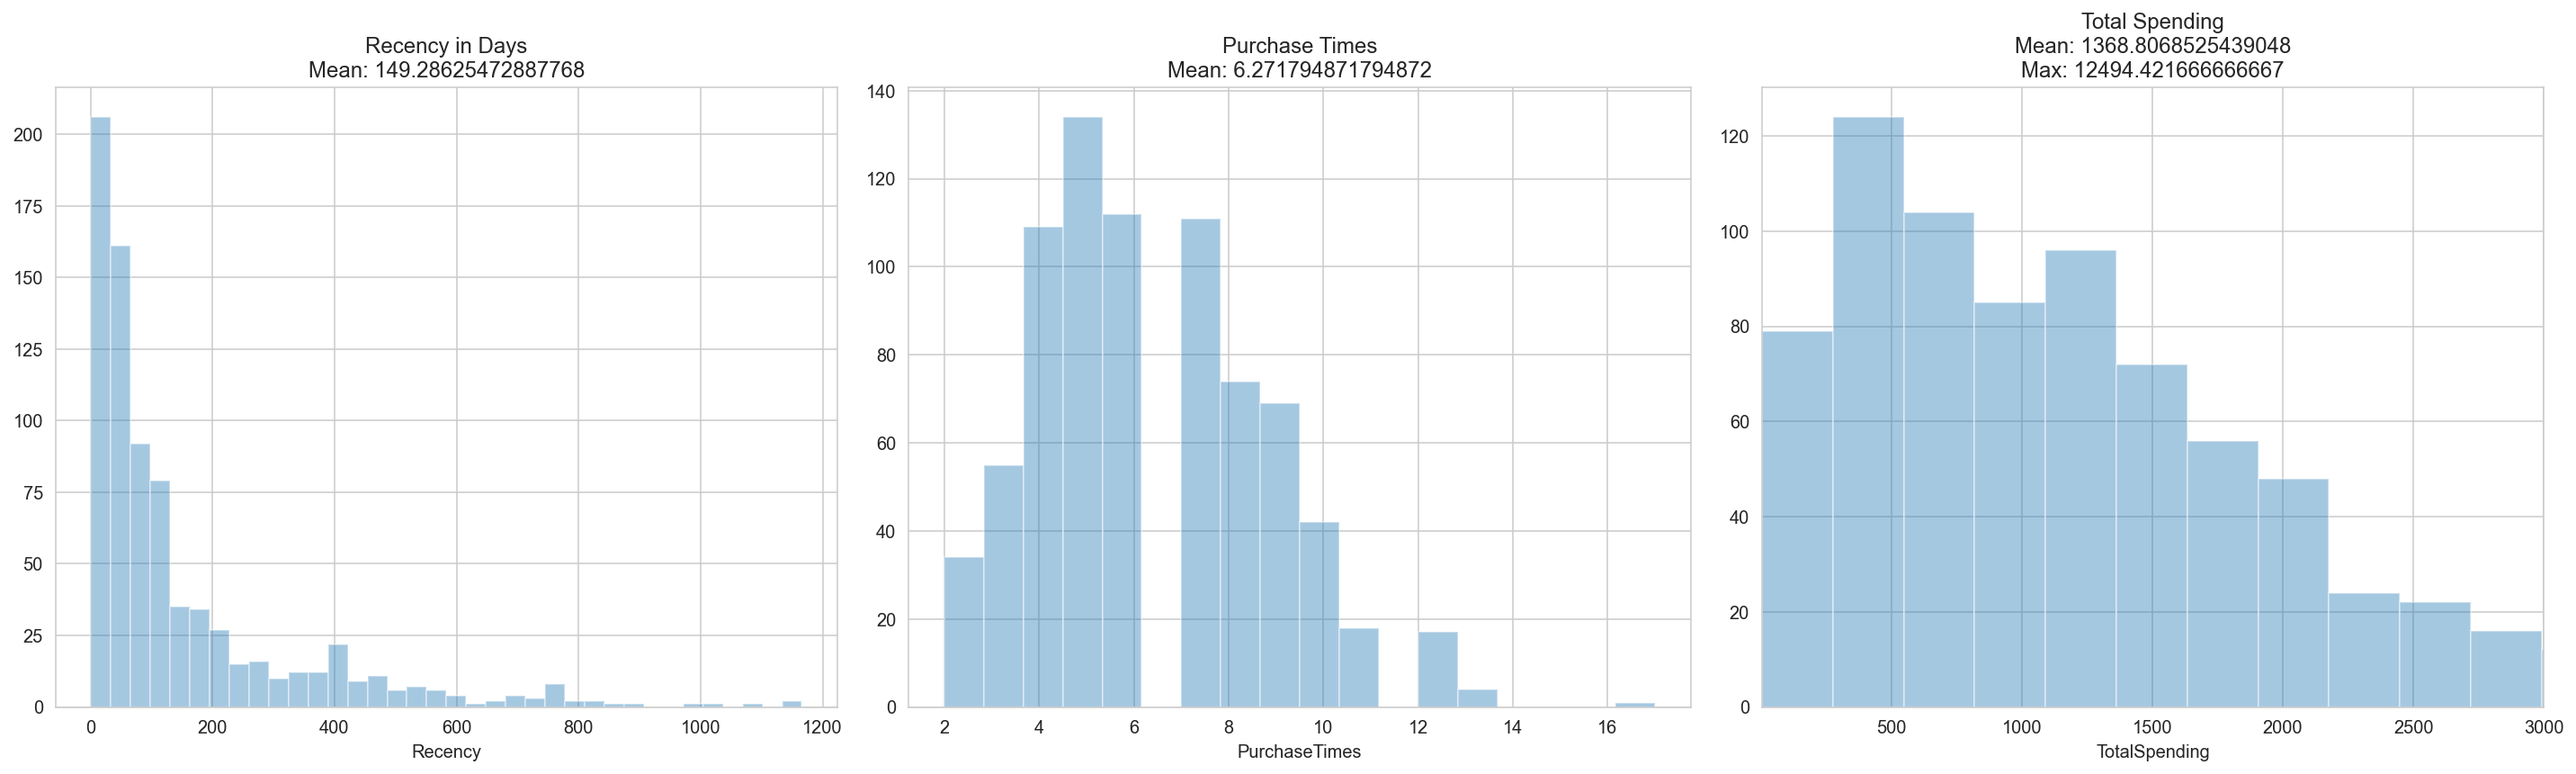

In [17]:
fig, ax = plt.subplots(1,3,figsize=(20,6))
sns.distplot(RFMsDF.Recency, kde = None, ax= ax[0])
ax[0].set_title("Recency in Days\n"+"Mean: "+str(RFMsDF.Recency.mean()))
sns.distplot(RFMsDF.PurchaseTimes, kde = None, ax= ax[1])
ax[1].set_title("Purchase Times\n"+"Mean: "+str(RFMsDF.PurchaseTimes.mean()))
sns.distplot(RFMsDF.TotalSpending, kde = None, ax= ax[2])
ax[2].set_title("Total Spending\n"+"Mean: "+str(RFMsDF.TotalSpending.mean())+\
                "\nMax: "+str(RFMsDF.TotalSpending.max()))
ax[2].set_xlim(RFMsDF.TotalSpending.min(), 3000)
fig.tight_layout()
plt.show();

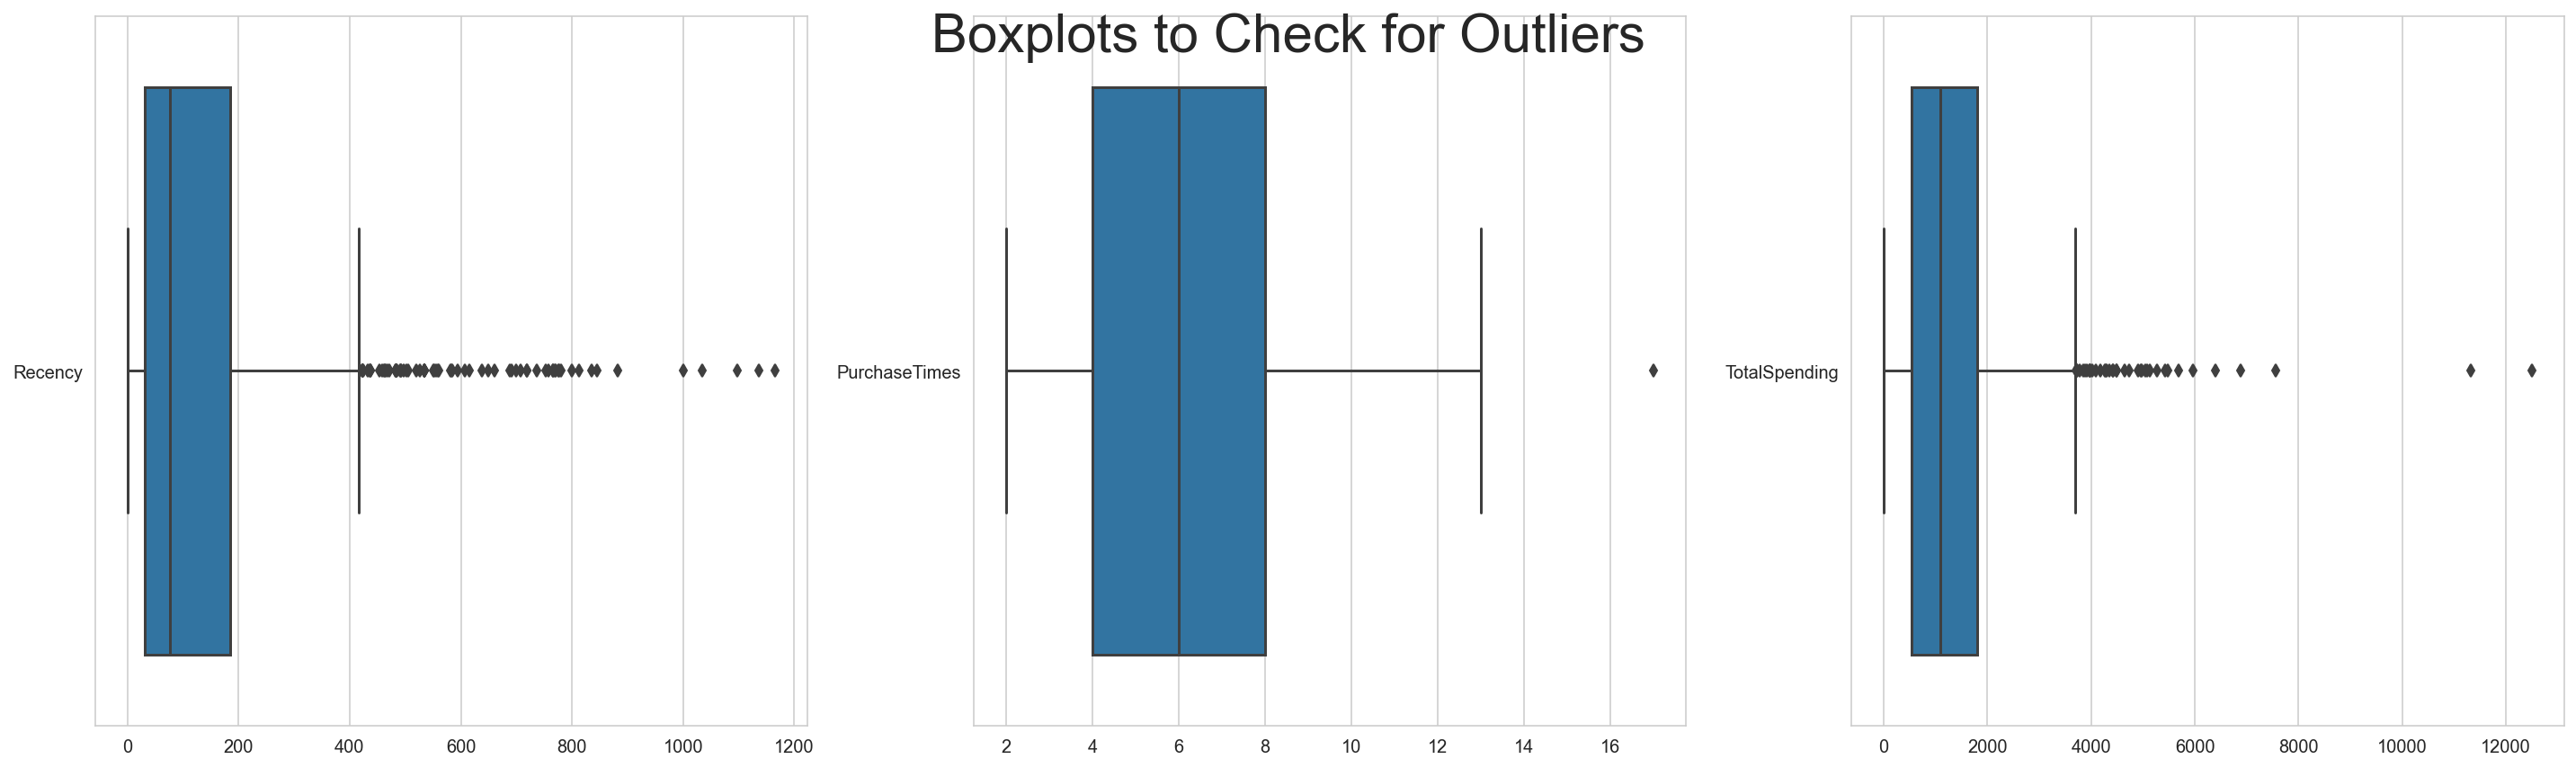

In [18]:
fig,ax = plt.subplots(1,3,figsize=(20,6))
fig.suptitle("Boxplots to Check for Outliers", fontsize=30)
sns.boxplot(data=RFMsDF[["Recency"]], ax=ax[0], orient="h")
sns.boxplot(data=RFMsDF[["PurchaseTimes"]],ax=ax[1], orient="h")
sns.boxplot(data=RFMsDF[["TotalSpending"]],ax=ax[2], orient="h")
fig.tight_layout()
plt.show();

### 2-5.顧客分類
* 對RFM數值進行分析，按照中位數進行判斷
* 1為低，2為高
  - R越大，表示顧客越久未發生交易，R越小，表示顧客越近有交易發生
  - F越大，表示顧客交易越頻繁，F越小，表示顧客不夠活躍 
  - M越大，表示顧客價值越高，M越小，表示顧客價值越低

In [19]:
RFMsDF['RR'] = np.where(RFMsDF.Recency<RFMsDF.Recency.median(),'2','1')
RFMsDF['FF'] = np.where(RFMsDF.PurchaseTimes>RFMsDF.PurchaseTimes.median(),'2','1')
RFMsDF['MM'] = np.where(RFMsDF.TotalSpending>RFMsDF.TotalSpending.median(),'2','1')
RFMsDF['RFM'] = RFMsDF.RR + RFMsDF.FF + RFMsDF.MM
RFMsDF.head()

,Customer ID,LatestPurchaseDate,Recency,MeanTurnover,StdTurnover,MinTurnover,MaxTurnover,PurchaseTimes,TotalSpending,MeanSpending,StdSpending,MinSpending,MaxSpending,RR,FF,MM,RFM
0,AA-10315,2018-06-29,185,296.50,163.899359,150.0,483.0,5.0,1693.742000,338.748400,449.321915,14.750,1101.518000,1,1,2,112
1,AA-10375,2018-12-11,20,166.25,74.754360,95.0,297.0,9.0,496.513667,55.168185,52.608110,5.248,171.173333,2,2,1,221
2,AA-10480,2018-04-15,260,359.00,397.998744,40.0,805.0,4.0,392.512000,98.128000,100.029261,15.552,231.596000,1,1,1,111
3,AA-10645,2018-11-05,56,246.40,145.942797,62.0,427.0,6.0,1565.269583,260.878264,243.076891,12.960,657.153333,2,1,2,212
4,AB-10015,2017-11-10,416,498.00,680.236724,17.0,979.0,3.0,397.791333,132.597111,137.058663,12.624,281.970000,1,1,1,111


* 顧客分類標準:建立一個分類規則，對顧客進行分類

In [20]:
label_list = {'222':'重要價值顧客','212':'重要保持顧客','122':'重要發展顧客','112':'重要挽留顧客',
       '221':'一般價值顧客','211':'一般發展顧客','121':'一般保持顧客','111':'潛在顧客'}
RFMsDF['level'] = [label_list[i] for i in RFMsDF.RFM.tolist()]
RFMsDF.head()

,Customer ID,LatestPurchaseDate,Recency,MeanTurnover,StdTurnover,MinTurnover,MaxTurnover,PurchaseTimes,TotalSpending,MeanSpending,StdSpending,MinSpending,MaxSpending,RR,FF,MM,RFM,level
0,AA-10315,2018-06-29,185,296.50,163.899359,150.0,483.0,5.0,1693.742000,338.748400,449.321915,14.750,1101.518000,1,1,2,112,重要挽留顧客
1,AA-10375,2018-12-11,20,166.25,74.754360,95.0,297.0,9.0,496.513667,55.168185,52.608110,5.248,171.173333,2,2,1,221,一般價值顧客
2,AA-10480,2018-04-15,260,359.00,397.998744,40.0,805.0,4.0,392.512000,98.128000,100.029261,15.552,231.596000,1,1,1,111,潛在顧客
3,AA-10645,2018-11-05,56,246.40,145.942797,62.0,427.0,6.0,1565.269583,260.878264,243.076891,12.960,657.153333,2,1,2,212,重要保持顧客
4,AB-10015,2017-11-10,416,498.00,680.236724,17.0,979.0,3.0,397.791333,132.597111,137.058663,12.624,281.970000,1,1,1,111,潛在顧客


In [21]:
Count_level = RFMsDF.groupby(['RFM','level'], as_index=False)['Customer ID'].count()
Count_level

,RFM,level,Customer ID
0,111,潛在顧客,196
1,112,重要挽留顧客,79
2,121,一般保持顧客,29
3,122,重要發展顧客,96
4,211,一般發展顧客,116
5,212,重要保持顧客,66
6,221,一般價值顧客,56
7,222,重要價值顧客,155


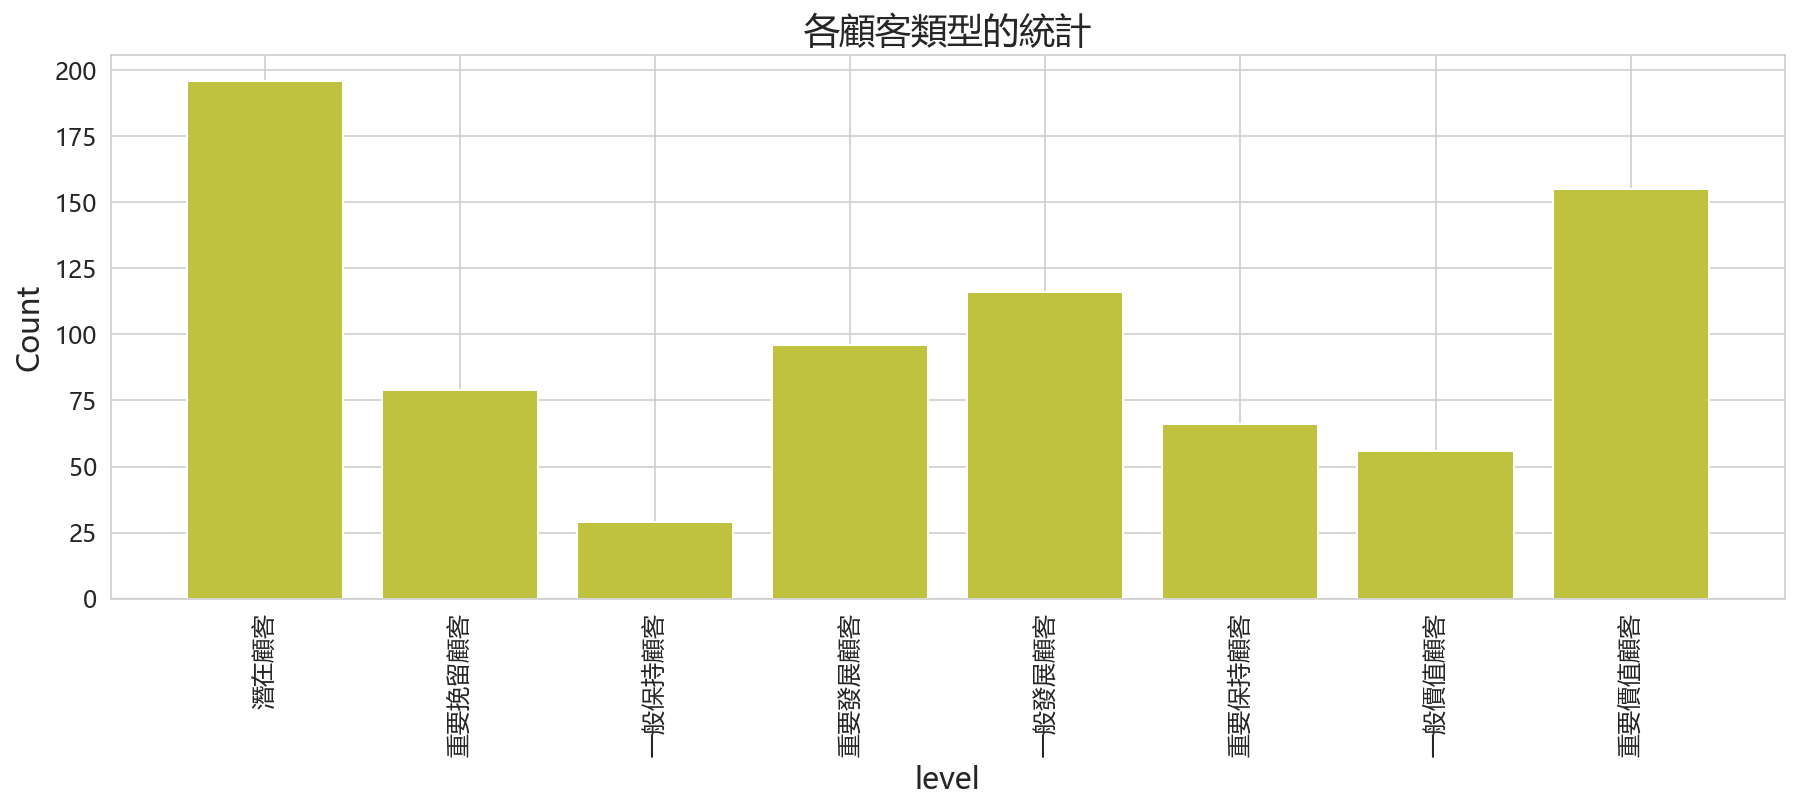

In [22]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("各顧客類型的統計", fontsize=18) 
plt.bar(Count_level["level"], Count_level["Customer ID"],color= '#BEC23F', linewidth = 1)
plt.xlabel("level",fontsize=15) # x axis shows the customers 
plt.ylabel("Count",fontsize=15) # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
#用來正常顯示中文標籤的 
plt.rcParams[ 'font.sans-serif'] =[ 'Microsoft YaHei'] 
#解決保存圖像是符號'-'顯示為方塊的問題 
plt.rcParams[ 'axes.unicode_minus'] = False

* <font  size=2>第一多的是"潛在顧客"，最近有消費，交易頻率和金額也不高，可對該部分使用者增加關懷，推送優惠資訊</font>
* <font  size=2>第二多的是"重要價值顧客"，RFM都很大，對這部分優質顧客要特殊保護</font>
* <font  size=2>第三多的是"一般發展顧客"，這部分顧客可能已經找到替代品或對該公司產品不感興趣了，因此無需浪費太多成本在這類顧客身上</font>

[返回目錄](#本章目錄)

## 3.找出消費金額最大的顧客(非原創)

In [23]:
Top_customers = SuperstoreSalesDataDF.groupby(["Customer Name"]).sum().sort_values("Sales", ascending=False).head(20) # Sort the Customers as per the sales
Top_customers = Top_customers[["Sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_customers.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the customer name into dataframe 

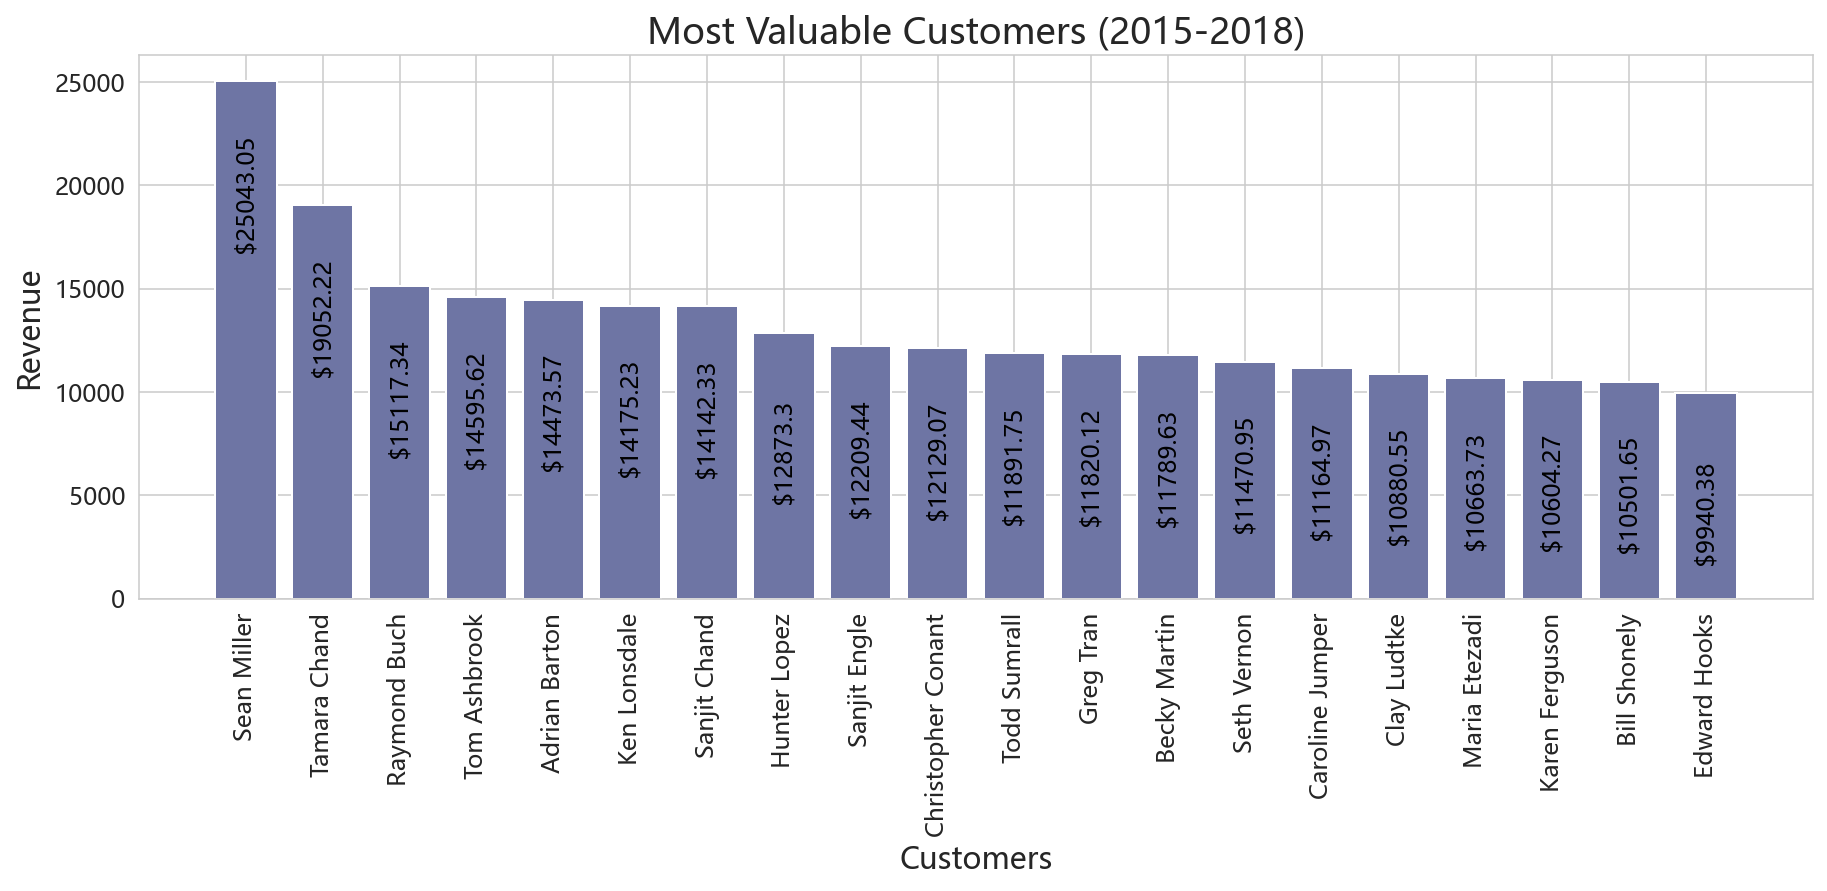

In [24]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("Most Valuable Customers (2015-2018)", fontsize=18) 
plt.bar(Top_customers["Customer Name"], Top_customers["Sales"],color= '#6E75A4', linewidth = 1)
plt.xlabel("Customers",fontsize=15) # x axis shows the customers 
plt.ylabel("Revenue",fontsize=15) # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
for k,v in Top_customers["Sales"].items(): #To show the exact revenue generated on the figure
    plt.text(k,v-8000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');

* <font  size=2>從上表可得知Sean Miller是消費金額最大的顧客</font>

[返回目錄](#本章目錄)

## 4.找出哪些州創造了最高的收入(非原創)
* Here are the Top 10 States which generated the highest revenue

In [25]:
Top_states = SuperstoreSalesDataDF.groupby(["State"]).sum().sort_values("Sales", ascending=False).head(20) # Sort the States as per the sales
Top_states = Top_states[["Sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_states.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the states into dataframe

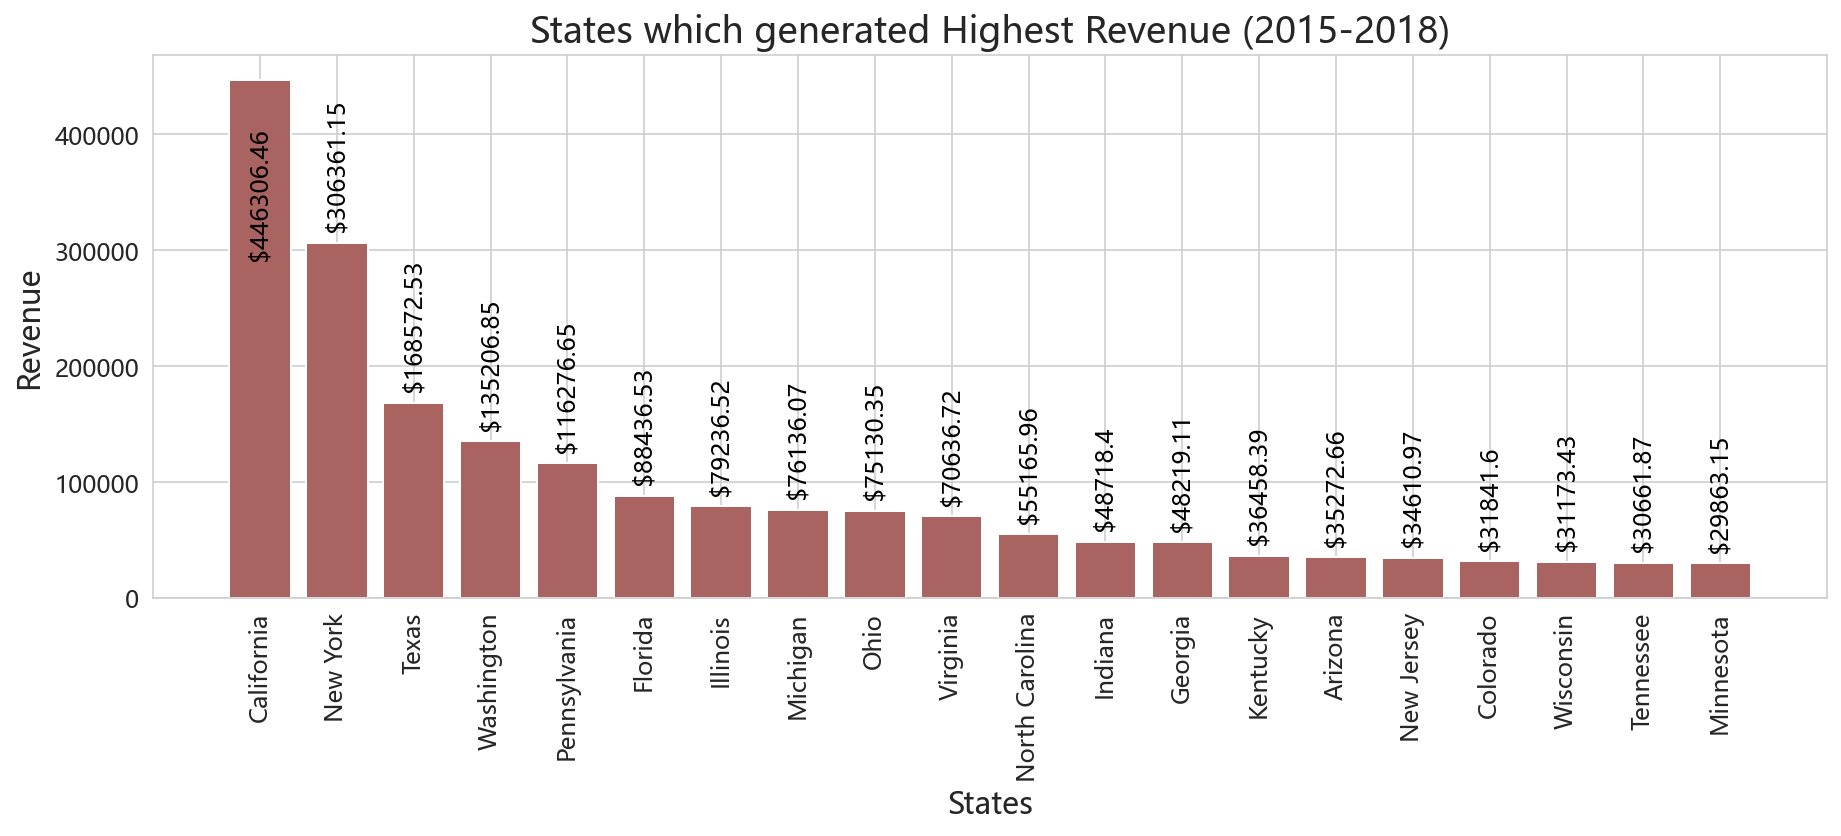

In [26]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("States which generated Highest Revenue (2015-2018)", fontsize=18) 
plt.bar(Top_states["State"], Top_states["Sales"],color= '#A96360', linewidth = 1)
plt.xlabel("States",fontsize=15) # x axis shows the States
plt.ylabel("Revenue",fontsize=15) # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
for k,v in Top_states["Sales"].items(): #To show the exact revenue generated on the figure
    if v>400000:
        plt.text(k,v-150000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');
    else:
        plt.text(k,v+15000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');

* <font  size=2>從上表可得知California這州創造了最高的收入</font>

[返回目錄](#本章目錄)

## 5.找出哪一座城市創造了最高的收入(非原創)
* Here are the top 10 cities which generated the highest revenue

In [27]:
Top_cities = SuperstoreSalesDataDF.groupby(["City"]).sum().sort_values("Sales", ascending=False).head(20) # Sort the States as per the sales
Top_cities = Top_cities[["Sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_cities.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the cities into the dataframe

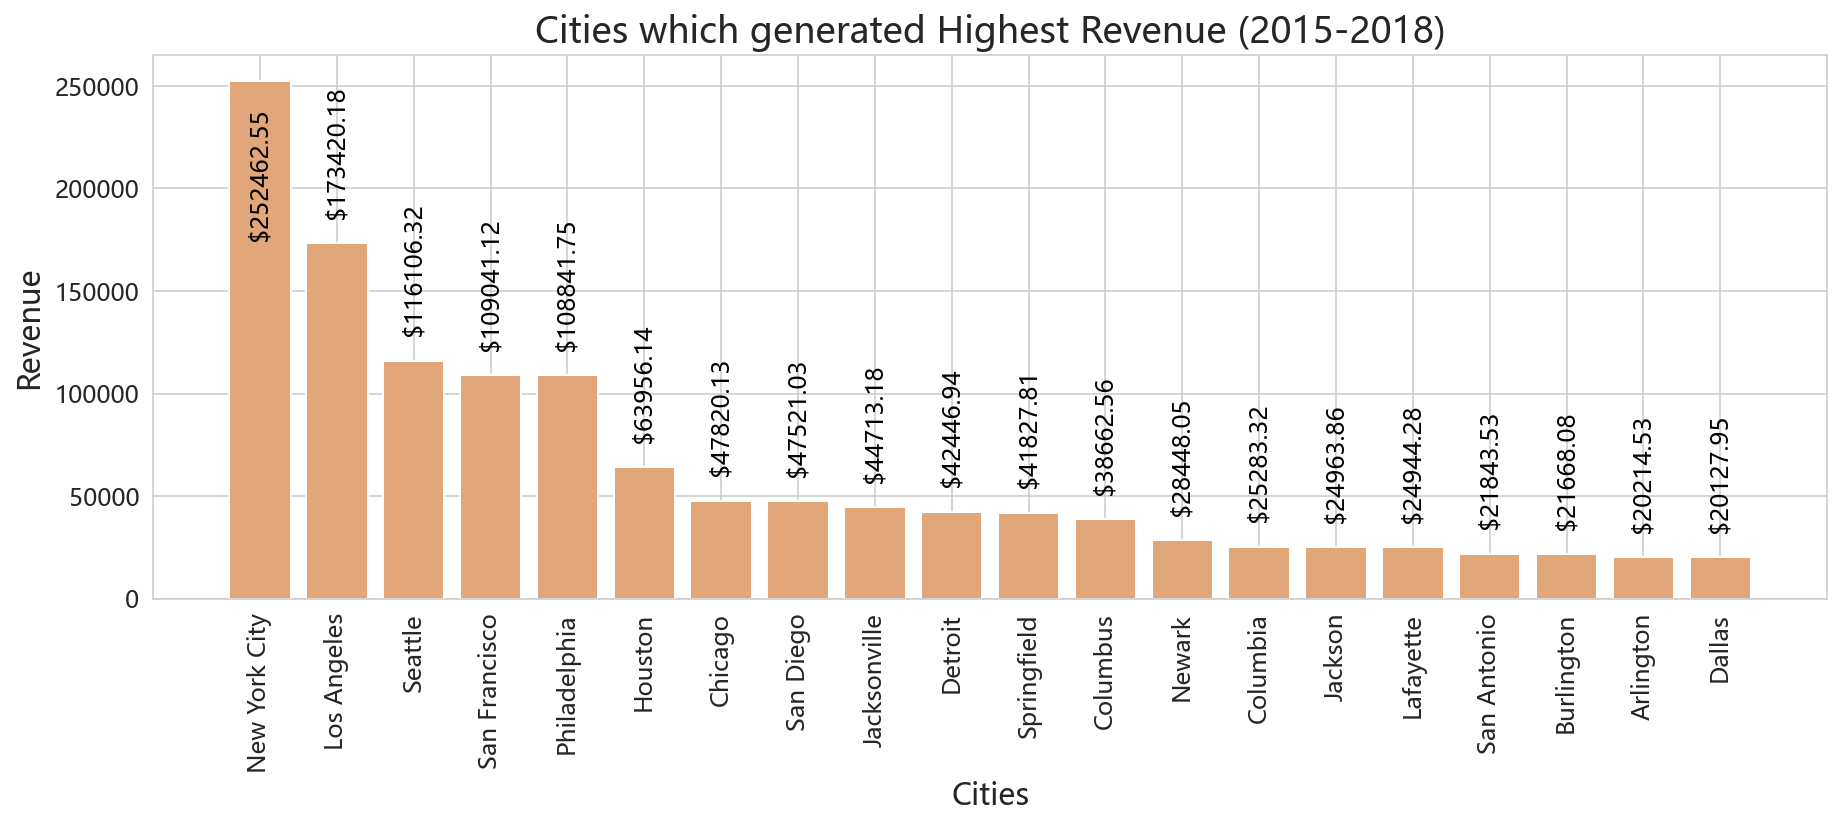

In [28]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("Cities which generated Highest Revenue (2015-2018)", fontsize=18)
plt.bar(Top_cities["City"], Top_cities["Sales"],color= '#E1A679', linewidth = 1)
plt.xlabel("Cities",fontsize=15)  # x axis shows the States
plt.ylabel("Revenue",fontsize=15)  # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
for k,v in Top_cities["Sales"].items(): #To show the exact revenue generated on the figure
    if v>250000:
        plt.text(k,v-75000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');
    else:
        plt.text(k,v+15000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');

[返回目錄](#本章目錄)

## 6.哪個地區銷售額最高(非原創)

* <font  size=2>從上表可得知New York City這城市創造了最高的收入</font>

In [29]:
Top_region = SuperstoreSalesDataDF.groupby(["Region"]).sum().sort_values("Sales", ascending=False) # Sort the Region as per the sales
Top_region = Top_region[["Sales"]].astype(int) # Cast Sales column to integer data type
Top_region.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the Region column into the data frame

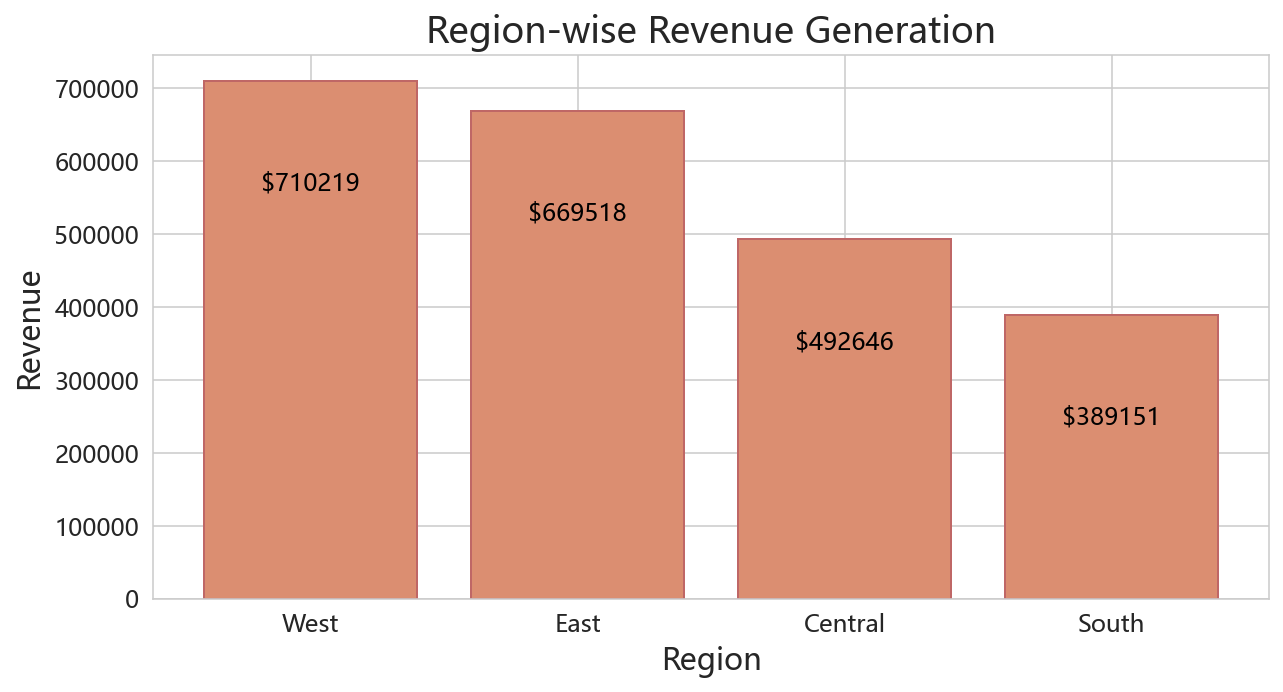

In [30]:
plt.figure(figsize = (10,5)) # width and height of figure is defined in inches
plt.title("Region-wise Revenue Generation", fontsize=18)
plt.bar(Top_region["Region"], Top_region["Sales"],color= '#DB8E71',edgecolor='#BF6766', linewidth = 1)
plt.xlabel("Region",fontsize=15) # x axis shows the Region 
plt.ylabel("Revenue",fontsize=15) # y axis show the Revenue generated
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for k,v in Top_region["Sales"].items(): #To show the exact revenue generated on the figure
        plt.text(k,v-150000,'$'+ str(v), fontsize=12,color='k', horizontalalignment='center');

* <font  size=2>West有710,219美元，這地區銷售額最高</font>

[返回目錄](#本章目錄)

## 7.分析每個類別的銷售(非原創)

In [31]:
Top_category = SuperstoreSalesDataDF.groupby(["Category"]).sum().sort_values("Sales", ascending=False)  # Sort the Categories as per the sales
Top_category = Top_category[["Sales"]] # keep only the sales column in the dataframe
total_revenue_category = Top_category["Sales"].sum() # To find the total revenue generated as per category
total_revenue_category = str(int(total_revenue_category)) # Convert the total_revenue_category from float to int and then to string
total_revenue_category = '$' + total_revenue_category # Adding '$' sign before the Value
Top_category.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the category into the dataframe

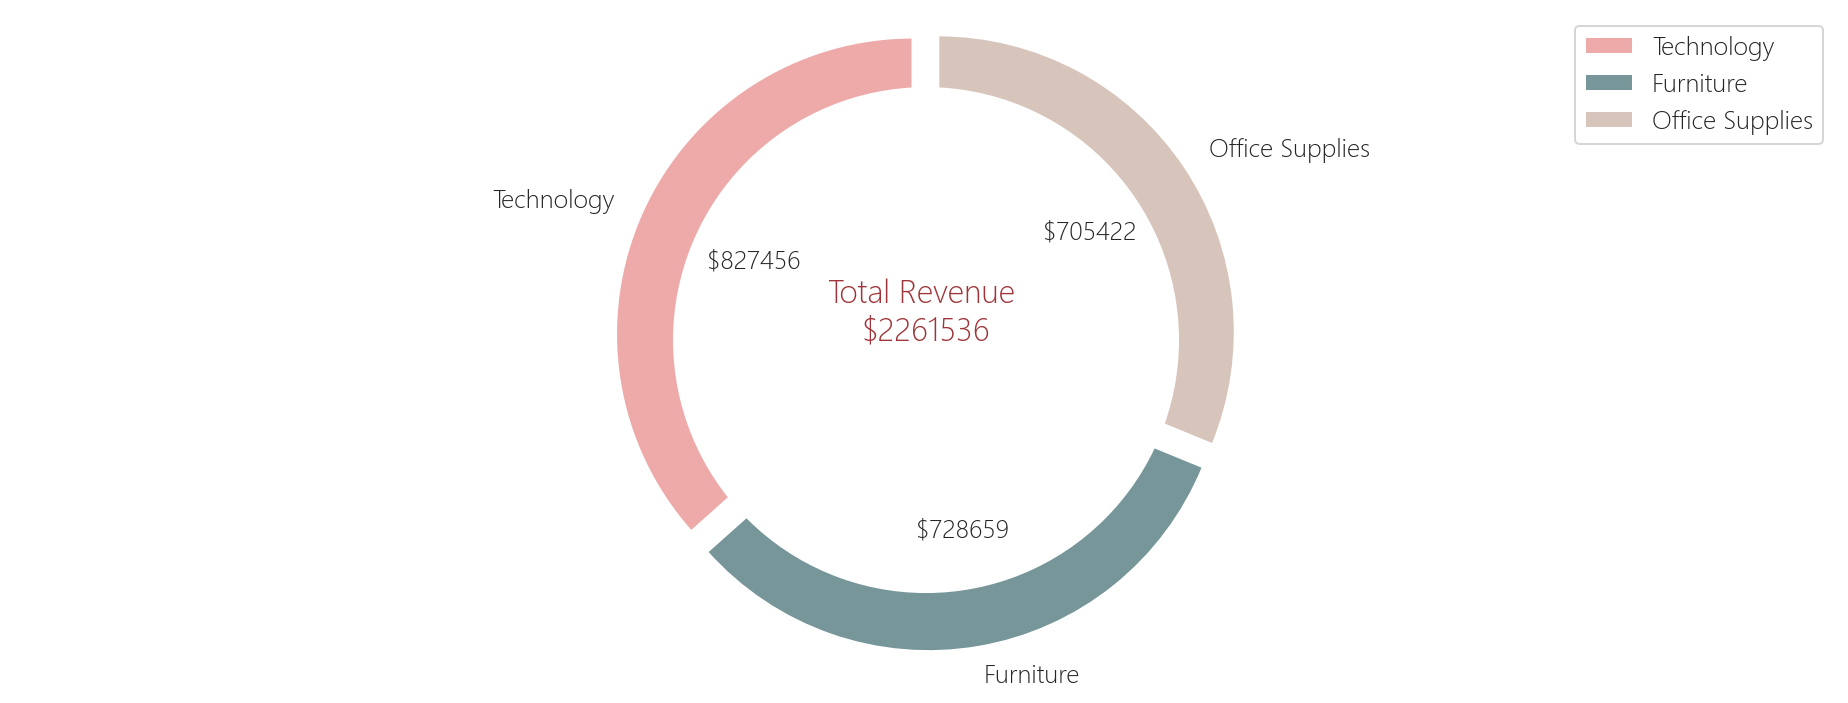

In [32]:
plt.rcParams["figure.figsize"] = (13,5) # width and height of figure is defined in inches
plt.rcParams['font.size'] = 12.0 # Font size is defined
plt.rcParams['font.weight'] = 6 # Font weight is defined
# we don't want to look at the percentage distribution in the pie chart. Instead, we want to look at the exact revenue generated by the categories.
def autopct_format(values): 
    def my_format(pct): 
        total = sum(values) 
        val = int(round(pct*total/100.0))
        return ' ${v:d}'.format(v=val)
    return my_format
colors = ['#EEA9A9','#77969A','#D7C4BB'] # Colors are defined for the pie chart
explode = (0.05,0.05,0.05)
fig1, ax1 = plt.subplots()
ax1.pie(Top_category['Sales'], colors = colors, labels=Top_category['Category'], autopct= autopct_format(Top_category['Sales']), startangle=90,explode=explode)
centre_circle = plt.Circle((0,0),0.85,fc='white') # drawing a circle on the pie chart to make it look better 
fig = plt.gcf()
fig.gca().add_artist(centre_circle) # Add the circle on the pie chart
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
# we can look the total revenue generated by all the categories at the center
label = ax1.annotate('Total Revenue \n'+str(total_revenue_category),color = '#9F353A', xy=(0, 0), fontsize=15, ha="center")
plt.legend(loc = "best")
plt.tight_layout()
plt.show()

* <font  size=2>Category:Technology有827,426美元，是最高收入的類別</font>
* <font  size=2>所有類別的總收入為2,261,536美元</font>

[返回目錄](#本章目錄)

## 8.哪些產品對收入的貢獻最大(非原創)

In [33]:
Top_products = SuperstoreSalesDataDF.groupby(["Product Name"]).sum().sort_values("Sales",ascending=False).head(8) # Sort the product names as per the sales
Top_products = Top_products[["Sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_products.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the product names into the dataframe
total_revenue_products = Top_products["Sales"].sum() # To find the total revenue generated by all the top products
total_revenue_products = str(int(total_revenue_products)) # Convert the total_revenue_products from float to int and then to string
total_revenue_products = '$' + total_revenue_products # Adding '$' sign before the Value

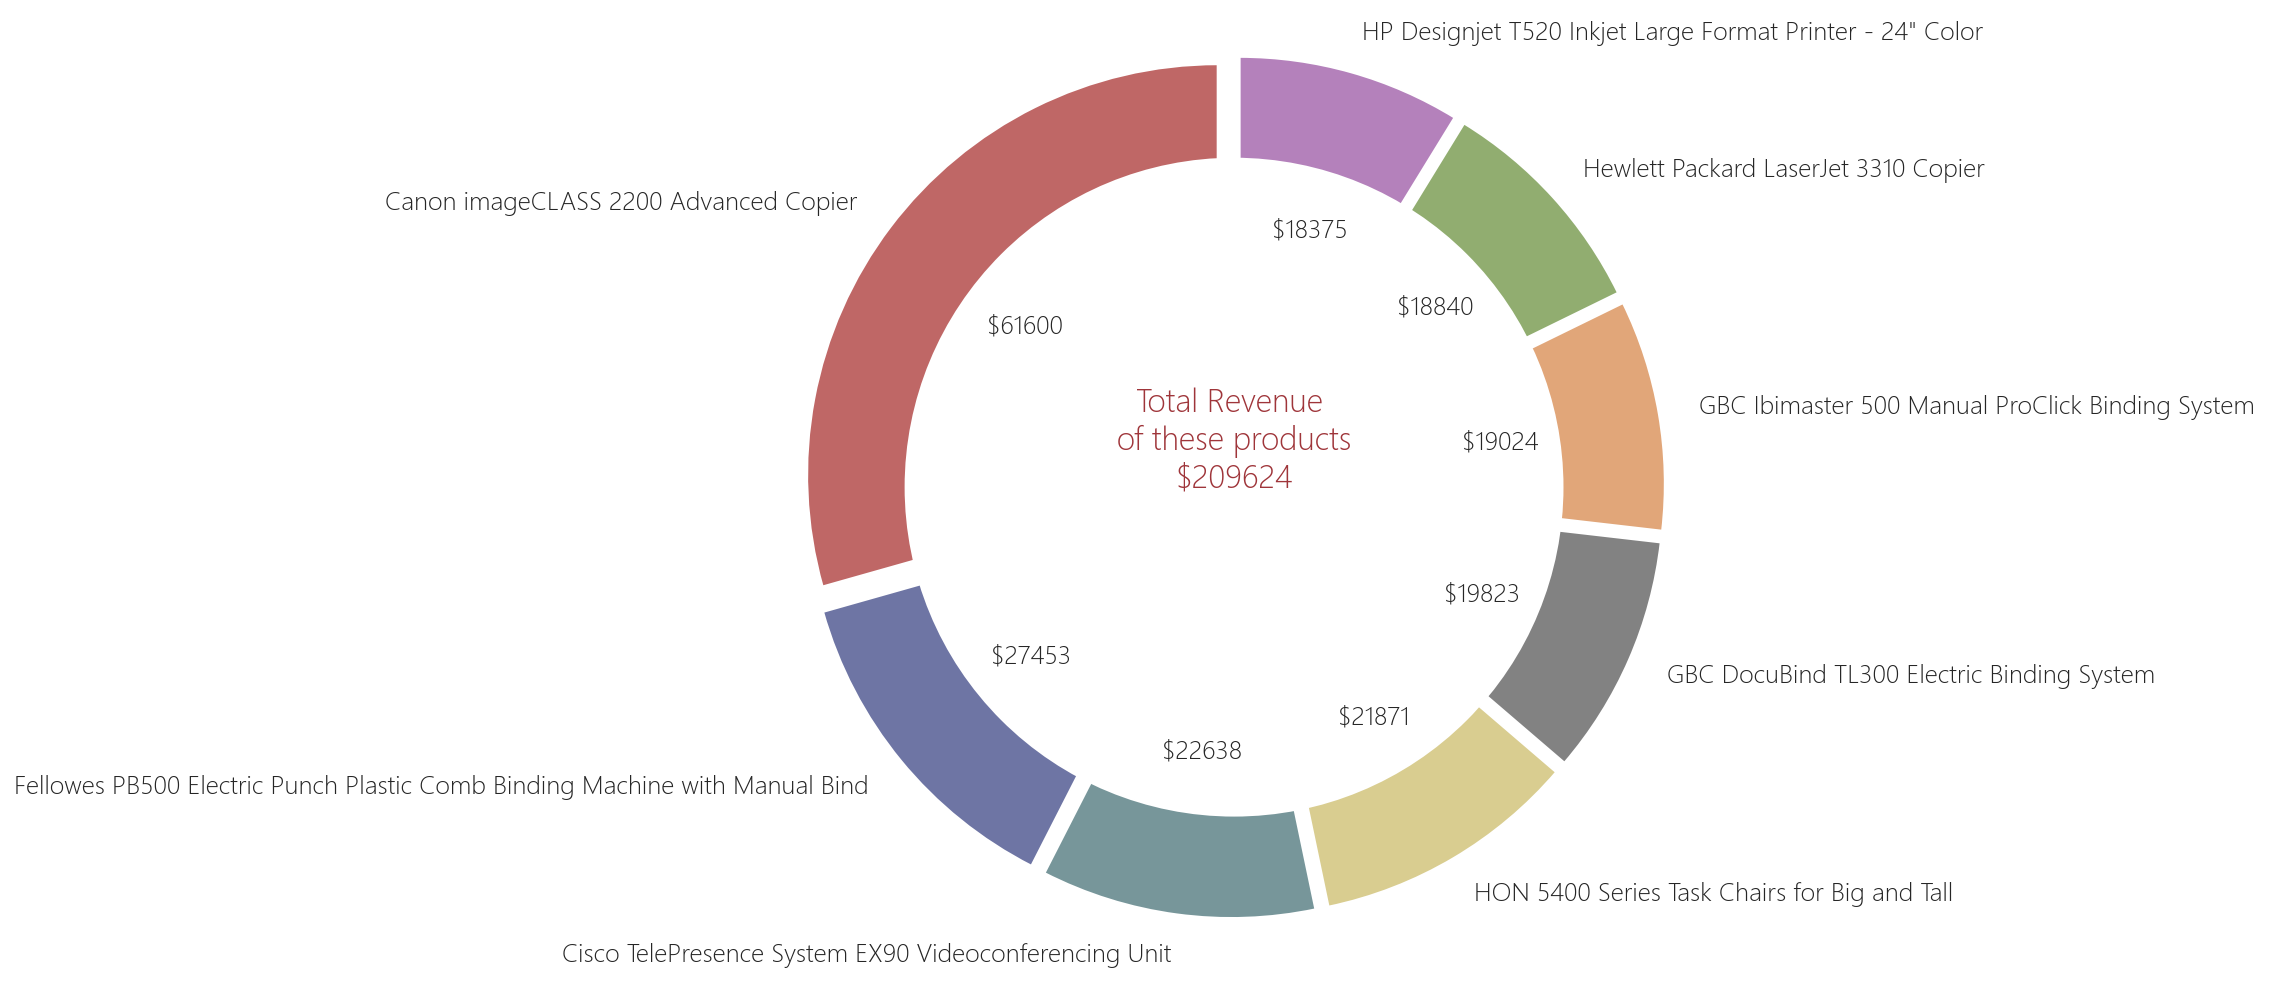

In [34]:
plt.rcParams["figure.figsize"] = (13,7) # width and height of figure is defined in inches
plt.rcParams['font.size'] = 12.0 # Font size is defined for the figure
colors = ['#BF6766','#6E75A4','#77969A','#D9CD90','#828282','#E1A679','#91AD70','#B481BB'] # colors are defined for the pie chart
explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)
fig1, ax1 = plt.subplots()
ax1.pie(Top_products['Sales'], colors = colors, labels=Top_products['Product Name'], autopct= autopct_format(Top_products['Sales']), startangle=90,explode=explode)
centre_circle = plt.Circle((0,0),0.80,fc='white') # Draw a circle on the pie chart
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
label = ax1.annotate('Total Revenue \n of these products \n'+str(total_revenue_products),color = '#9F353A', xy=(0, 0), fontsize=15, ha="center")
plt.tight_layout()
plt.show()

* <font  size=2>Product:Canon imageCLASS 2200 Advanced Copier有61,600美元，是最高收入的產品</font>
* <font  size=2>所有產品的總收入為209,624美元</font>

[返回目錄](#本章目錄)

## 9.每個子類別的銷售(非原創)

In [35]:
# Sort both category and  sub category as per the sales
Top_subcat = SuperstoreSalesDataDF.groupby(['Category','Sub-Category']).sum().sort_values("Sales", ascending=False).head(10)
Top_subcat = Top_subcat[["Sales"]].astype(int) # Cast Sales column to integer data type
Top_subcat = Top_subcat.sort_values("Category") # Sort the values as per Category
Top_subcat.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add both columns into data frame
Top_subcat_1 = Top_subcat.groupby(['Category']).sum() # Calculated the total Sales of all the categories
Top_subcat_1.reset_index(inplace=True) # Reset the index

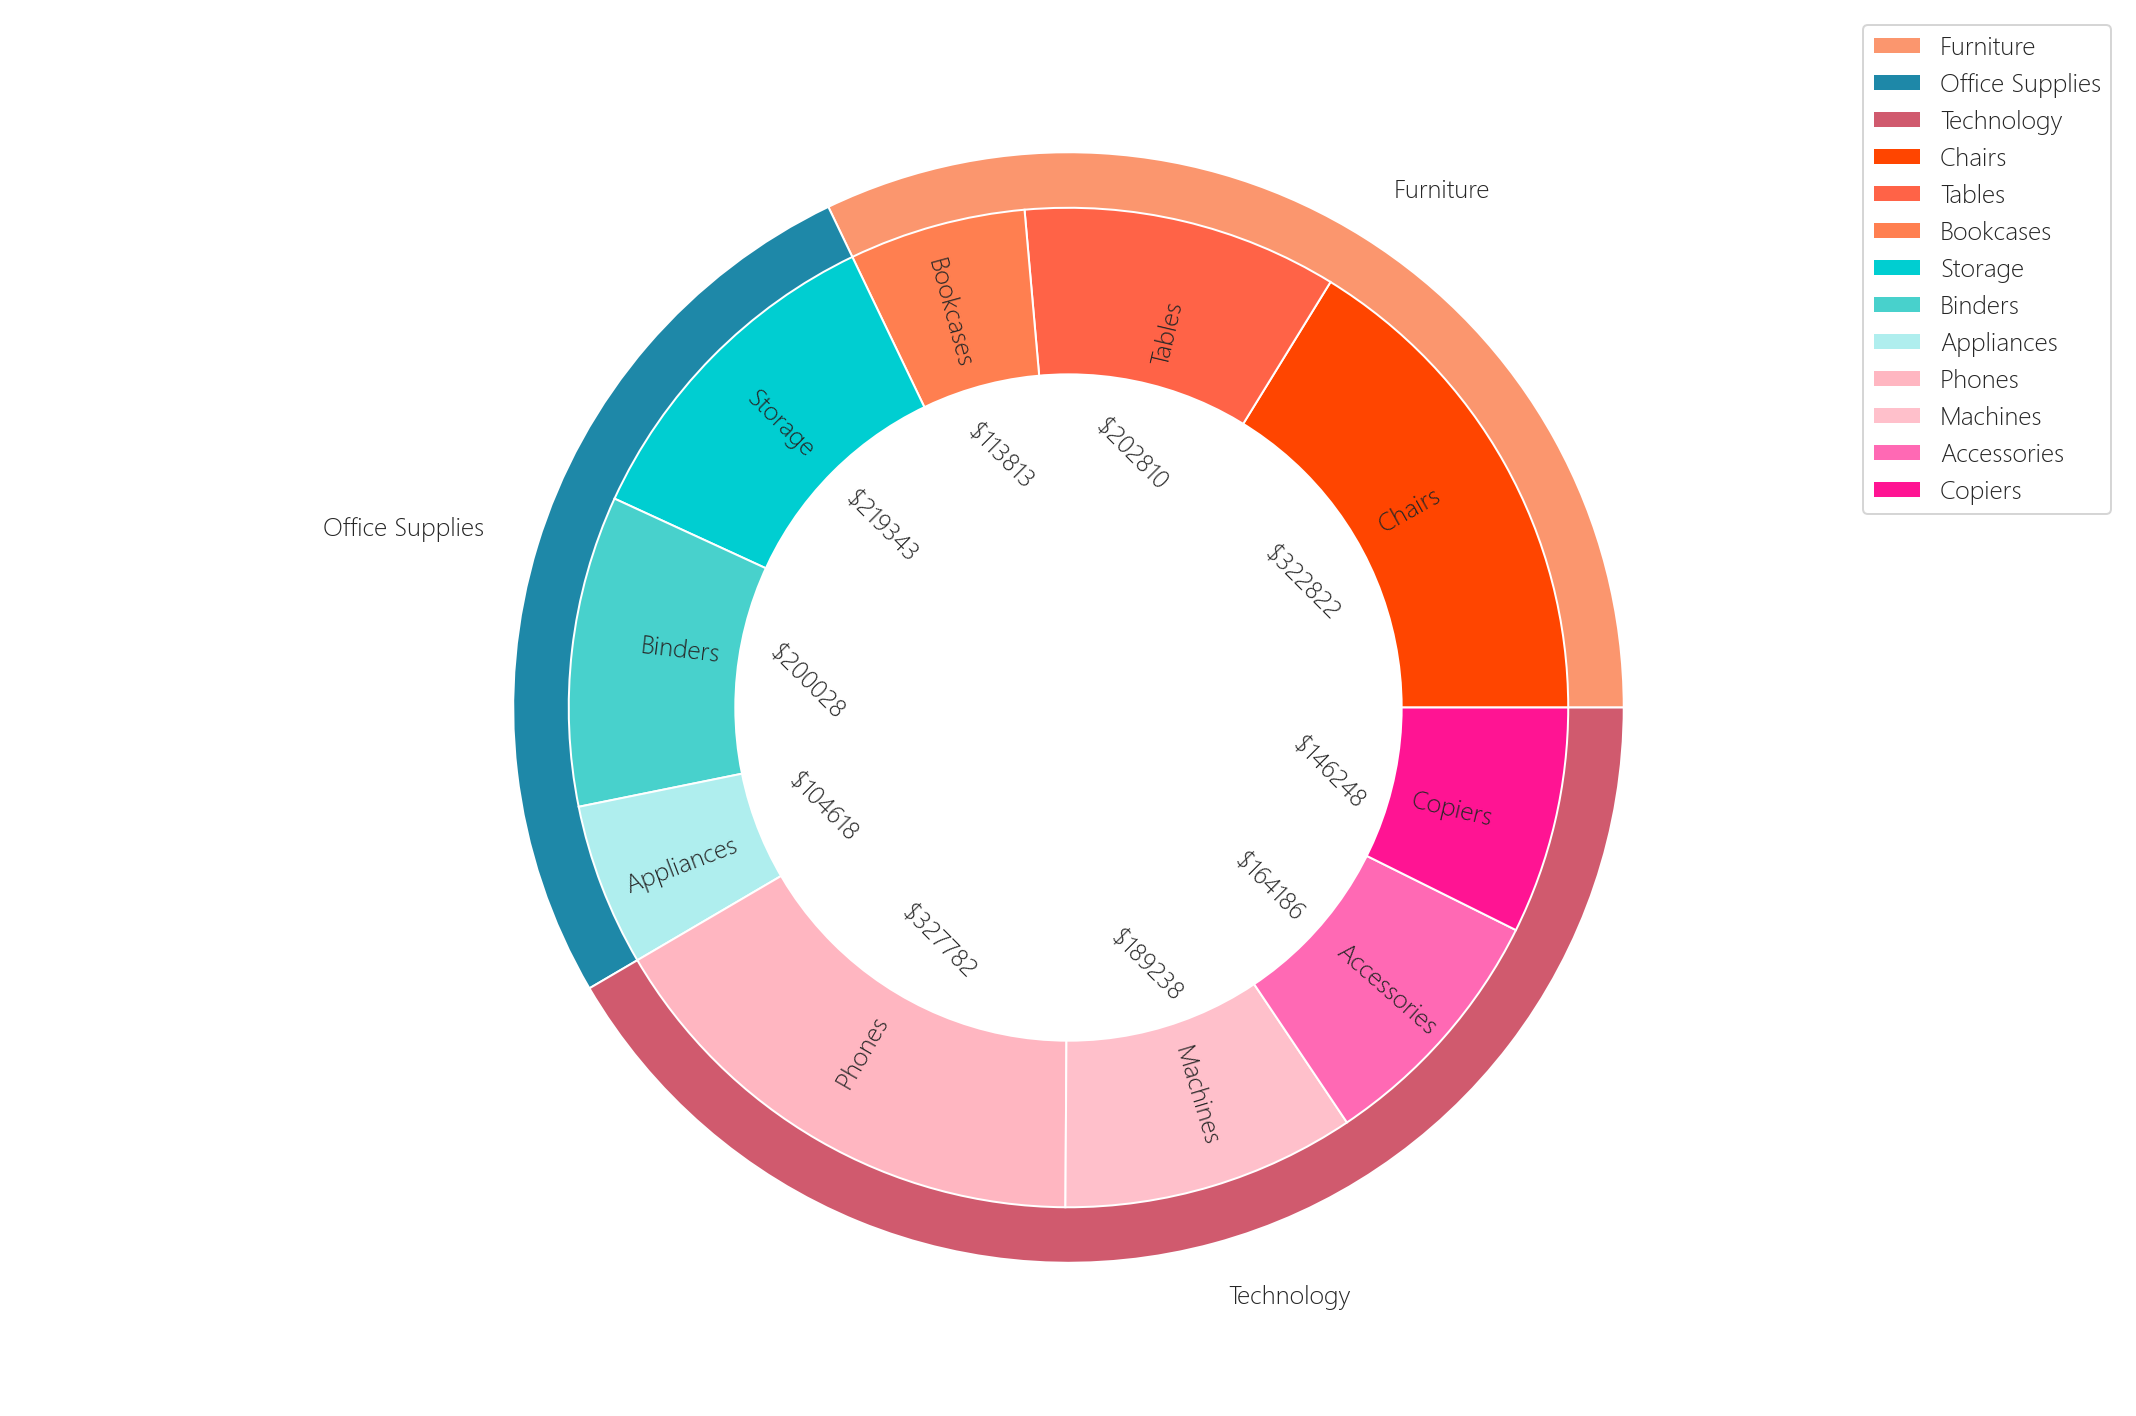

In [36]:
plt.rcParams["figure.figsize"] = (15,10) # width and height of figure is defined in inches
fig, ax = plt.subplots()
ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle
width = 0.1
outer_colors = ['#FB966E','#1E88A8','#D05A6E'] # Outer colors of the pie chart
inner_colors = ['Orangered','tomato','coral',"darkturquoise","mediumturquoise","paleturquoise","lightpink","pink","hotpink","deeppink"] # inner colors of the pie chart
pie = ax.pie(Top_subcat_1['Sales'], radius=1, labels=Top_subcat_1['Category'],colors=outer_colors,wedgeprops=dict(edgecolor='w'))
pie2 = ax.pie(Top_subcat['Sales'], radius=1-width, labels=Top_subcat['Sub-Category'],autopct= autopct_format(Top_subcat['Sales']),labeldistance=0.7,colors=inner_colors,wedgeprops=dict(edgecolor='w'), pctdistance=0.53,rotatelabels =True)
# Rotate fractions
# [0] = wedges, [1] = labels, [2] = fractions
fraction_text_list = pie2[2]
for text in fraction_text_list: 
    text.set_rotation(315) # rotate the autopct values
centre_circle = plt.Circle((0,0),0.6,fc='white') # Draw a circle on the pie chart
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(loc = "best")
ax1.axis('equal')  
plt.tight_layout()
plt.show()

* <font  size=2>Sub-Category:Phones有327,782美元，是最高收入的子類別的產品</font>

[返回目錄](#本章目錄)

## 10.分析不同市場的銷售(非原創)

In [37]:
Top_segment = SuperstoreSalesDataDF.groupby(["Segment"]).sum().sort_values("Sales", ascending=False) # Sort the segment as per the sales
Top_segment = Top_segment[["Sales"]] # keep only the sales column in the dataframe
Top_segment.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the segment column into the data frame
total_revenue_segement = Top_segment["Sales"].sum() # To find the total revenue generated as per segment
total_revenue_segement = str(int(total_revenue_segement)) # Convert the total_revenue_segment from float to int and then to string
total_revenue_segement= '$' + total_revenue_segement # Adding '$' sign before the Value

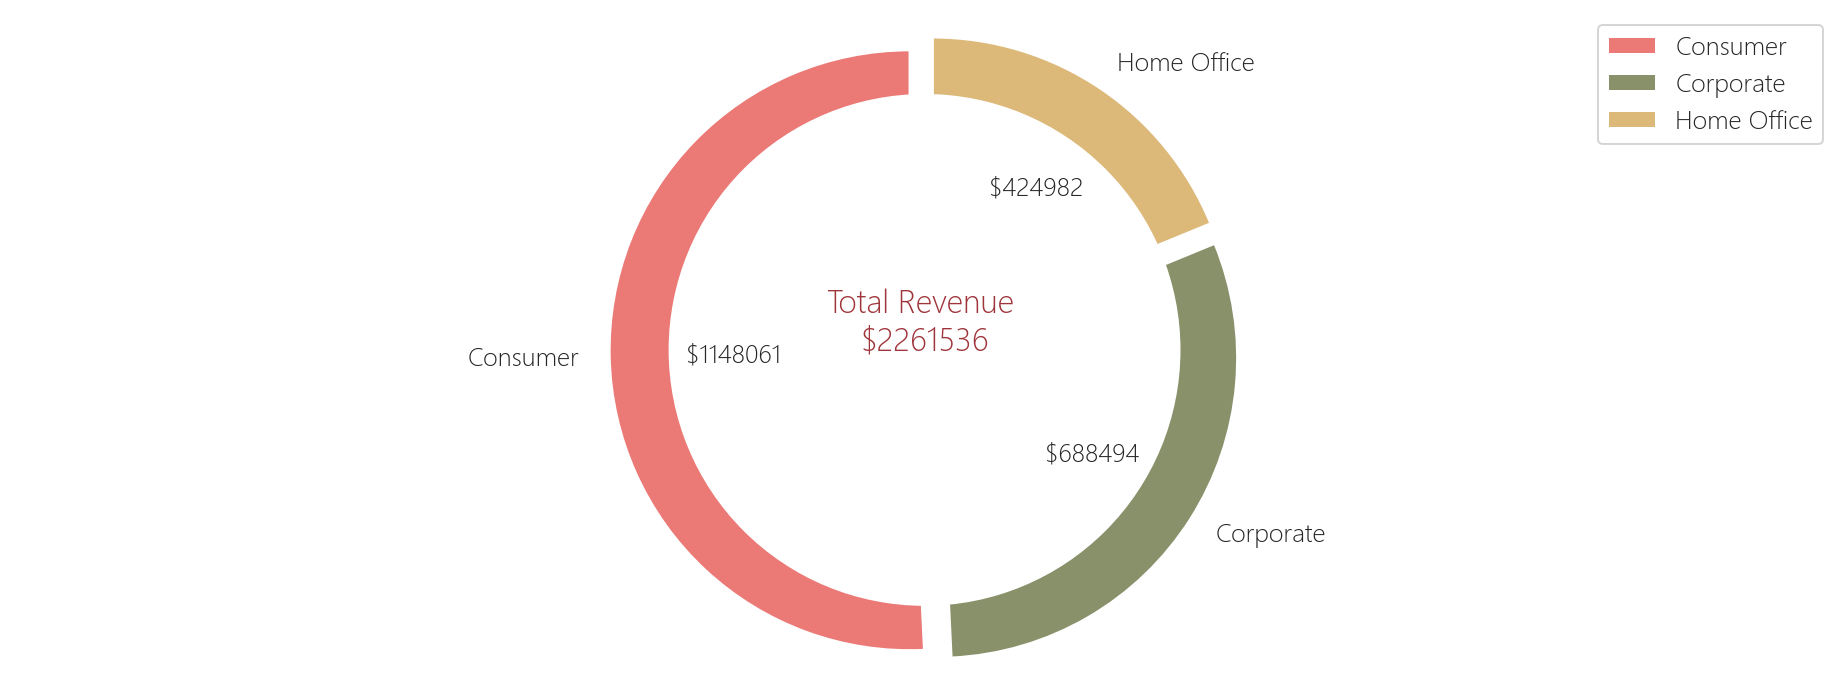

In [38]:
plt.rcParams["figure.figsize"] = (13,5) # width and height of figure is defined in inches
plt.rcParams['font.size'] = 12.0 # Font size is defined
plt.rcParams['font.weight'] = 6 # Font weight is defined
colors = ['#EB7A77','#89916B','#DCB879'] # Colors are defined for the pie chart
explode = (0.05,0.05,0.05)
fig1, ax1 = plt.subplots()
ax1.pie(Top_segment['Sales'], colors = colors, labels=Top_segment['Segment'], autopct= autopct_format(Top_segment['Sales']),startangle=90,explode=explode)
centre_circle = plt.Circle((0,0),0.85,fc='white') # Draw a circle on the pie chart
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
label = ax1.annotate('Total Revenue \n'+str(total_revenue_segement),color = '#9F353A', xy=(0, 0), fontsize=15, ha="center")
plt.legend(loc = "best")
plt.tight_layout()
plt.show()

* <font  size=2>Consumer有1148,061美元，顧客市場大部分來自Consumer</font>

[返回目錄](#本章目錄)

## 11.相關性Heatmap視覺化圖(非原創)

* <font  size=2>顧客市場及與銷售的線性狀況</font>

                        Sales  Segment_Consumer  Segment_Corporate  \
Sales                1.000000         -0.009483           0.002496   
Segment_Consumer    -0.009483          1.000000          -0.684237   
Segment_Corporate    0.002496         -0.684237           1.000000   
Segment_Home Office  0.009388         -0.485111          -0.305772   

                     Segment_Home Office  
Sales                           0.009388  
Segment_Consumer               -0.485111  
Segment_Corporate              -0.305772  
Segment_Home Office             1.000000  


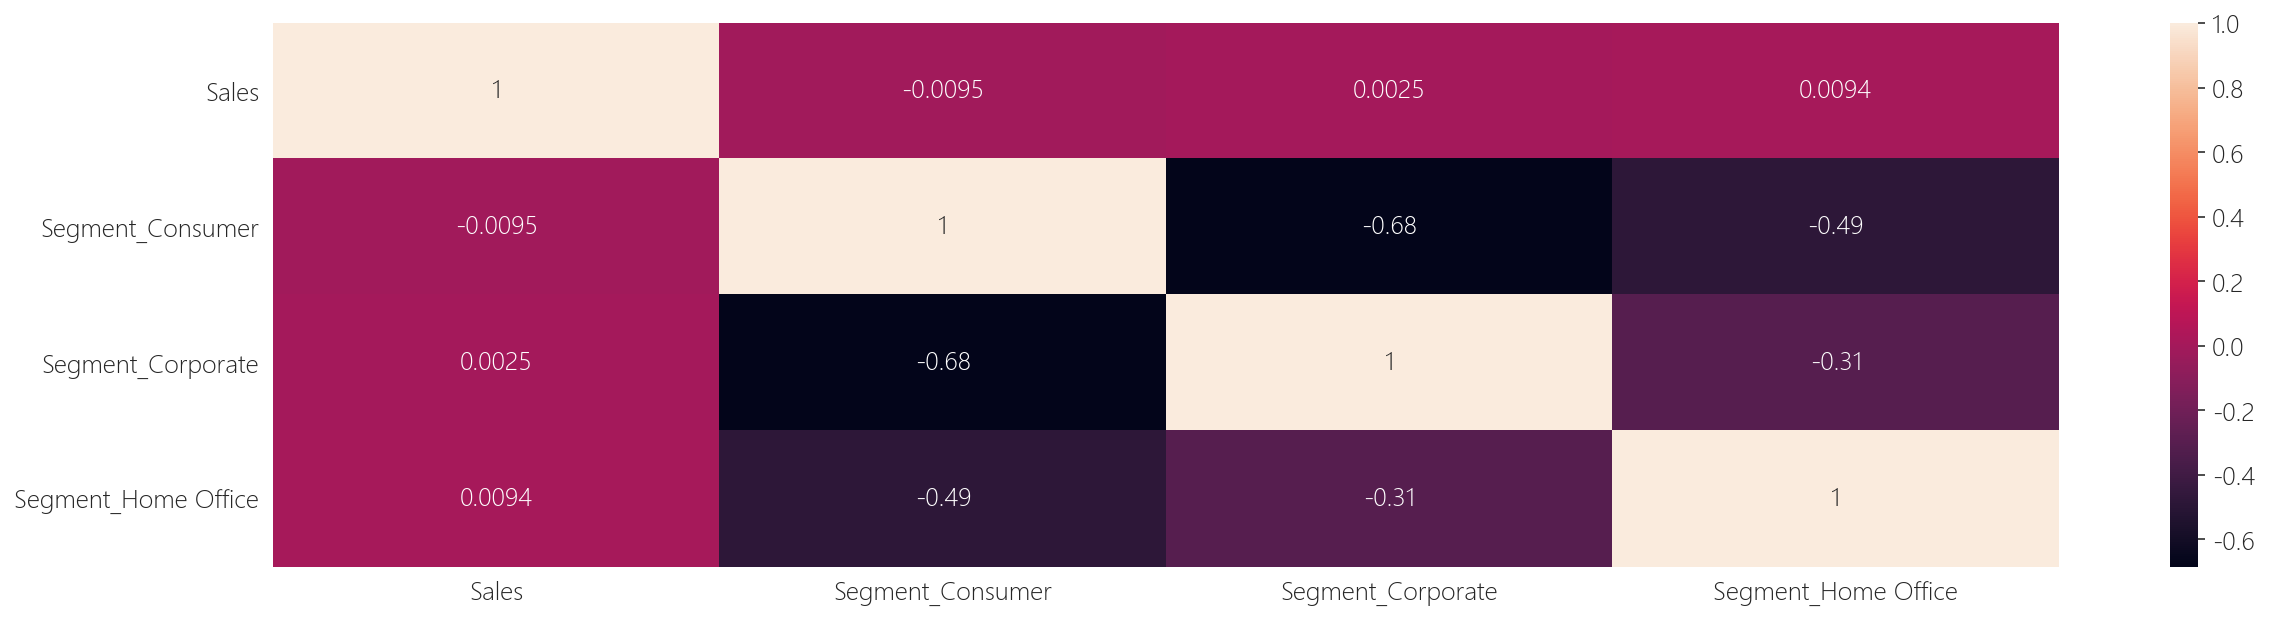

In [39]:
corrcoef = SuperstoreSalesDataDF[['Segment','Sales']]
df_cat = pd.get_dummies(corrcoef)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(20,5)
print(cor_mat)
sns.heatmap(cor_mat, xticklabels = cor_mat.columns, yticklabels = cor_mat.columns, annot=True);

* <font  size=2>產品類別及與銷售的線性狀況</font>

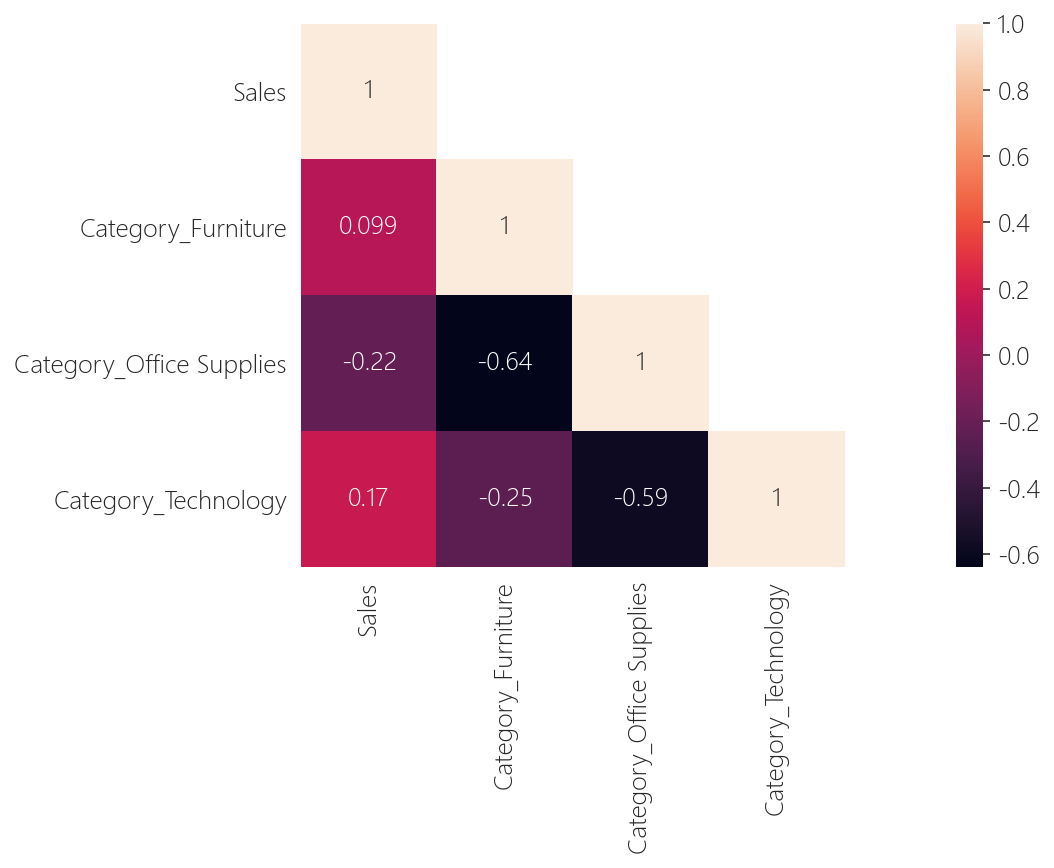

In [40]:
df1 = SuperstoreSalesDataDF[['Category','Sales']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(20,5)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

[返回目錄](#本章目錄)

## 12.整體銷售情況分析(原創)

* ### 首先建立整體銷售情況的子數據集：

In [41]:
SalesDF = SuperstoreSalesDataDF[['Order Date','Sales']]
SalesDF.sample(5)

,Order Date,Sales
291,2017-11-20,255.984
4650,2018-04-08,244.550
2574,2015-11-22,16.230
6824,2016-07-25,358.580
9230,2018-07-23,58.320


In [42]:
# 將Order Date提取出"年"與"月份"
from datetime import datetime
TransactionEndingDate = datetime.strptime('2018-12-31', '%Y-%m-%d')
SalesDF['Order Date'] = SalesDF['Order Date'].astype('datetime64[ns]')
SalesDF['Year'] = SalesDF['Order Date'].dt.strftime('%Y')
SalesDF['Month'] = SalesDF['Order Date'].dt.strftime('%m')
SalesDF

,Order Date,Sales,Year,Month
7980,2015-01-03,16.448,2015,01
741,2015-01-04,3.540,2015,01
740,2015-01-04,272.736,2015,01
739,2015-01-04,11.784,2015,01
1759,2015-01-05,19.536,2015,01
...,...,...,...,...
1297,2018-12-30,20.720,2018,12
906,2018-12-30,323.136,2018,12
645,2018-12-30,209.300,2018,12
908,2018-12-30,52.776,2018,12


* ### 然後按照年份、月份對銷售子數據集進行分組求和：

In [43]:
sales_year = SalesDF.groupby(['Year', 'Month']).sum()
sales_year

Sales
Year Month             
2015 01      14205.7070
     02       4519.8920
     03      55205.7970
     04      27906.8550
     05      23644.3030
     06      34322.9356
     07      33781.5430
     08      27117.5365
     09      81623.5268
     10      31453.3930
     11      77907.6607
     12      68167.0585
2016 01      18066.9576
     02      11951.4110
     03      32339.3184
     04      34154.4685
     05      29959.5305
     06      23599.3740
     07      28608.2590
     08      36818.3422
     09      63133.6060
     10      31011.7375
     11      75249.3995
     12      74543.6012
2017 01      18542.4910
     02      22978.8150
     03      51165.0590
     04      38679.7670
     05      56656.9080
     06      39724.4860
     07      38320.7830
     08      30542.2003
     09      69193.3909
     10      59583.0330
     11      79066.4958
     12      95739.1210
2018 01      43476.4740
     02      19920.9974
     03      58863.4128
     04      35541.9101
     05      43825.9822
     06      48190.7277
     07      44825.1040
     08      62837.8480
     09      86152.8880
     10      77448.1312
     11     117938.1550
     12      83030.3888

* ### 對以上進行分組求和後的數據進行拆分，將每一年的數據作為獨立的表：

In [44]:
year_2015 = sales_year.loc["2015"].reset_index()
year_2016 = sales_year.loc["2016"].reset_index()
year_2017 = sales_year.loc["2017"].reset_index()
year_2018 = sales_year.loc["2018"].reset_index()
year_2018

,Month,Sales
0,01,43476.4740
1,02,19920.9974
2,03,58863.4128
3,04,35541.9101
4,05,43825.9822
5,06,48190.7277
6,07,44825.1040
7,08,62837.8480
8,09,86152.8880
9,10,77448.1312


* ### 銷售額分析

In [45]:
# 建立銷售額表
sales = pd.concat([year_2015['Sales'],year_2016['Sales'],
                  year_2017['Sales'],year_2018['Sales']], axis=1)

# 對行、列重新命名
sales.columns = ['Sales_2015', 'Sales_2016', 'Sales_2017', 'Sales_2018']
sales.index = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# 添加顏色：顏色越深表示銷售額越高
sales.style.background_gradient()

,Sales_2015,Sales_2016,Sales_2017,Sales_2018
01,14205.707000,18066.957600,18542.491000,43476.474000
02,4519.892000,11951.411000,22978.815000,19920.997400
03,55205.797000,32339.318400,51165.059000,58863.412800
04,27906.855000,34154.468500,38679.767000,35541.910100
05,23644.303000,29959.530500,56656.908000,43825.982200
06,34322.935600,23599.374000,39724.486000,48190.727700
07,33781.543000,28608.259000,38320.783000,44825.104000
08,27117.536500,36818.342200,30542.200300,62837.848000
09,81623.526800,63133.606000,69193.390900,86152.888000
10,31453.393000,31011.737500,59583.033000,77448.131200


* 由上表可知:
  - 2015年2月銷售金額最低，9月銷售金額最高
  - 2016年2月銷售金額最低，11月銷售金額最高
  - 2017年1月銷售金額最低，12月銷售金額最高
  - 2018年2月銷售金額最低，11月銷售金額最高

In [46]:
# 計算每年銷售額
sales_sum = sales.sum()

# 計算銷售額增長率
rise_12 = (sales_sum[1]-sales_sum[0]) / sales_sum[0]
rise_23 = (sales_sum[2]-sales_sum[1]) / sales_sum[1]
rise_34 = (sales_sum[3]-sales_sum[2]) / sales_sum[2]
rise_rate = [0, rise_12, rise_23, rise_34]

sales_sum = pd.DataFrame({'sales_sum': sales_sum})
sales_sum['rise_rate'] = rise_rate
sales_sum

,sales_sum,rise_rate
Sales_2015,479856.2081,0.000000
Sales_2016,459436.0054,-0.042555
Sales_2017,600192.5500,0.306368
Sales_2018,722052.0192,0.203034


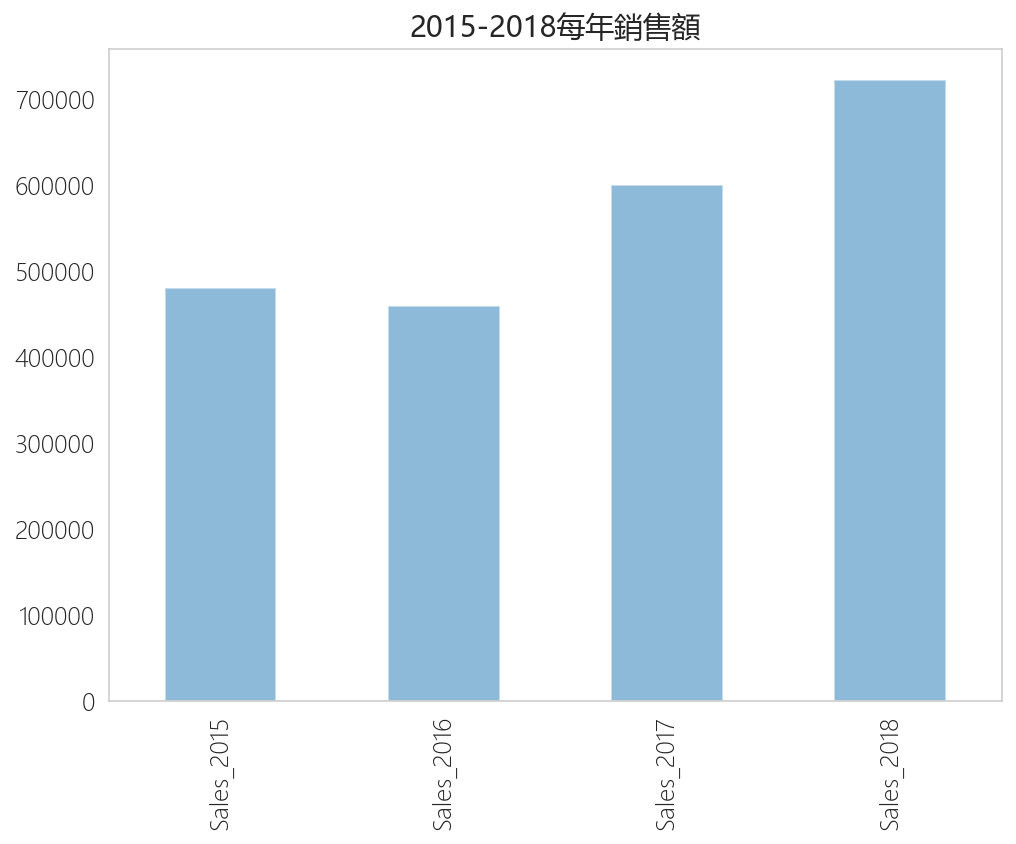

In [47]:
# 展示每年銷售額
sales_sum['sales_sum'].plot(kind='bar', alpha=0.5, figsize=(8,6))
plt.grid()
plt.title('2015-2018每年銷售額')
plt.show()

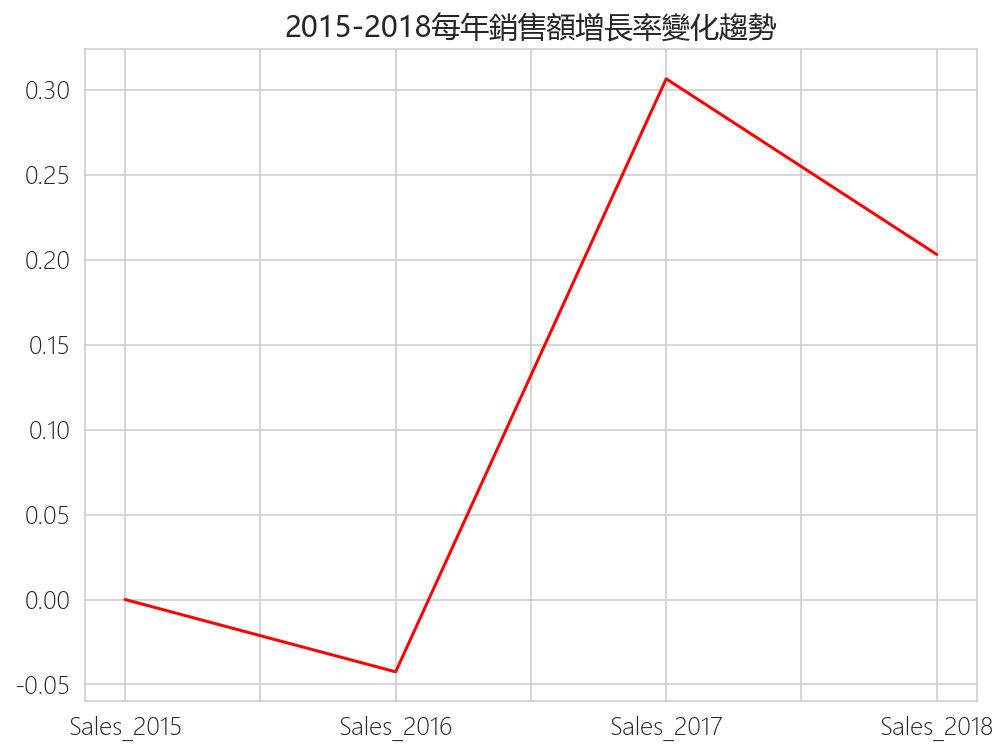

In [48]:
# 展示增長率
sales_sum['rise_rate'].plot(color='red', figsize=(8,6))
plt.title('2015-2018每年銷售額增長率變化趨勢')
plt.show()

*  2016年銷售額下滑，2017年銷售額上漲約30%，2018年的銷售額也比2015年好約20%

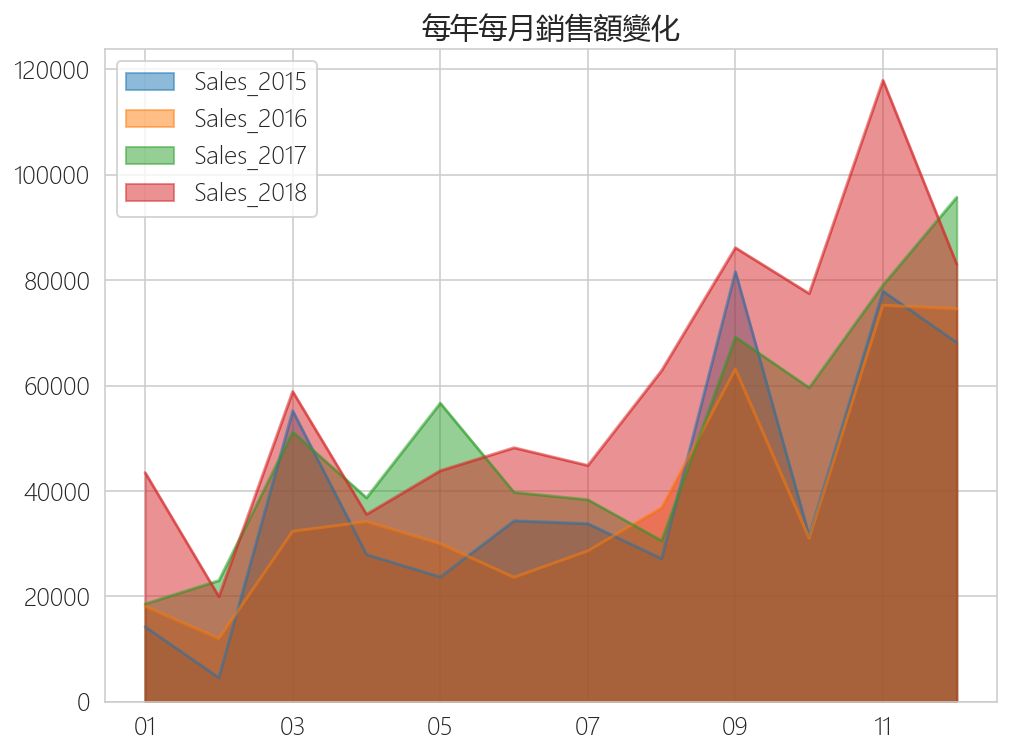

In [49]:
sales.plot.area(stacked=False, figsize=(8,6))
plt.title('每年每月銷售額變化')
plt.show()

* ### 從堆積圖可以大致看出該超市的銷售季節性明顯，總體情況是上半年為淡季，下半年為旺季。
  * 對於旺季的月份，運營推廣等策略要繼續維持，還可以加大投入，提高整體銷售額。
  * 對於淡季的月份，可以結合產品特點進行新產品擴展，舉辦一些促銷活動等來吸引用戶。

[返回目錄](#本章目錄)